In [309]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


best_so_far.png					 projekt.ipynb	todo.txt
Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg  README.md


In [5]:
target_img.shape

(749, 512)

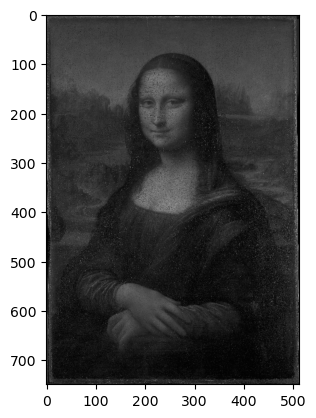

In [46]:
resize_to=512
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255

plt.imshow(target_img, cmap='gray')
plt.show()

# define circles

In [11]:
class Circle:
    def __init__(self, cords, r, o, rgb, image_shape=(381, 256, 3)):
        self.x=cords[0] 
        self.y=cords[1]
        
        self.radius=r
        self.opacity=o
        self.rgb=rgb
       # self.g=rgb[1]
       # self.b=rgb[2]
        
        self.img_shape=image_shape
    def get_patch(self):
        return plt.Circle((self.x, self.y), 
                          radius=self.radius, 
                          alpha=self.opacity,
                          color=self.rgb)
    def draw_cv2(self, X):
        return cv2.circle(X, 
                  (self.x, self.y), 
                  self.radius, 
                  self.rgb,
                  thickness=-1)
        

In [12]:
def random_circle(max_radius=target_img.shape[1]):
    cords_seed=np.random.random(2)
    cords=(int(cords_seed[0]*target_img.shape[1]),
           int(cords_seed[1]*target_img.shape[0]))
    r=int(np.random.random()*100)
    o=np.random.random()
    rgb=np.random.random(3)
    return Circle(cords, r, o, rgb)

In [13]:

no_circles=100
# each circle has LOCATION (x,y), RADIUS, OPACITY, COLOUR (rgb), 
circles=[]
for i in range(no_circles):
    circles.append(random_circle())

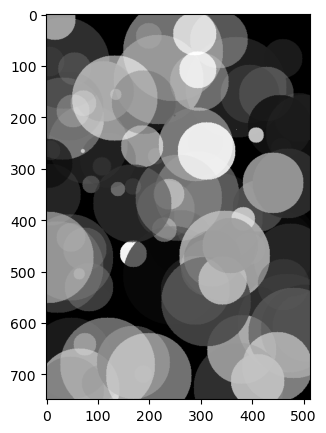

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

X=np.zeros(target_img.shape)
for c in circles:
  #  circle_img=X.copy()
    circle_img=c.draw_cv2(X.copy())
    X=cv2.addWeighted(X, 1-c.opacity, circle_img, c.opacity, 0)

plt.imshow(X, cmap='gray')
plt.show()

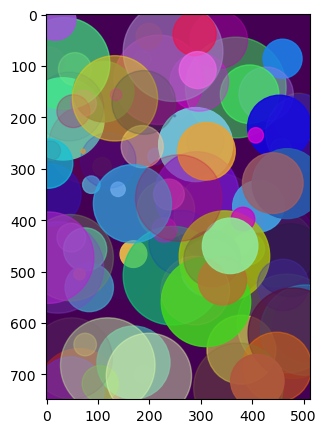

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))


X=np.zeros(target_img.shape)
ax.imshow(X)
for c in circles:
    ax.add_patch(c.get_patch())
plt.show()

# ES

In [353]:
def random_circle(gray=False, 
                  max_radius_scale=1.0, max_opacity_scale=1.0):
    '''Function generating random circles.
    Cirlce is presented as a numpy array lenght 8 in such scheme
    [x, y, radius, opacity, r, g, b]

    Returns:
        circle (numpy array length 7): the generated circle
    '''
    if gray:
        lows=np.zeros(5)
        highs=np.ones(5)
        lows[2]=0.25*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale
        
        circle=np.random.uniform(lows, highs, 5)
    else:
        lows=np.zeros(7)
        highs=np.ones(7)
        lows[2]=0.25*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale
       
        circle=np.random.uniform(lows, highs, 7)
    return circle

In [357]:
def random_individual(chromosome_length, genotype_len=7, gray=False, 
                      max_radius_scale=1.0,  max_opacity_scale=1.0):
    '''Function generating random individual.
    Args:
        chromosome_length (int): number of figures in an individual
        genotype (int): lenght of a gene (defaults 7 for circle)
    Returns:
        indiv (numpy array shaped (chromosome_length, genotype)): the generated individual
    '''
    indiv = np.zeros((chromosome_length, genotype_len))
    if gray:
        if genotype_len == 5: # circle
            for i in range(chromosome_length):
                indiv[i] = random_circle(gray, 
                                         max_radius_scale=max_radius_scale, 
                                         max_opacity_scale=max_opacity_scale)
    else:
        if genotype_len == 7: # circle
            for i in range(chromosome_length):
                indiv[i] = random_circle(max_radius_scale=max_radius_scale,
                                         max_opacity_scale=max_opacity_scale)
    
    return indiv

In [356]:
def random_population(population_size, chromosome_length, genotype_len=7, gray=False, 
                      max_radius_scale=1.0, max_opacity_scale=1.0):
    '''Function generating random population.
    Args:
        population_size (int): number of individuals in the population
        chromosome_length (int): number of figures in and individual
        genotype (int): length of a gene (defaults 7 for circle)
    
    Returns:
        population: generated population
    '''
    population = np.zeros((population_size, chromosome_length, genotype_len))
    for i in range(population_size):
        population[i] = random_individual(chromosome_length, genotype_len, gray, 
                                          max_radius_scale, max_opacity_scale)
    
    return population

In [232]:
max_radius=np.sqrt(pow(target_img.shape[0],2)+pow(target_img.shape[1], 2))/2

def represent_individual(X):
    X_img=np.zeros(target_img.shape)
    for c in X:
        #[x, y, radius, opacity, r, g, b]
        x=int(c[0]*target_img.shape[1])
        y=int(c[1]*target_img.shape[0])
        radius=int(c[2]*max_radius)
        opacity=c[3]
        rgb=c[4:]
        circle_img=cv2.circle(X_img.copy(), 
                              (x, y), 
                              radius, 
                              rgb,
                              thickness=-1)
        X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
    return X_img

In [376]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_X_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [234]:
#flatten_target_image=target_img.flatten()
def MSE_objective_f(X_img):
    #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
    pom = target_img - X_img
    return np.sum(pom*pom)

In [389]:
def mutate_population(population, scale=1e-1, mut_prob=0.4):
    mutation_indices = (np.random.random(population.shape) < mut_prob).astype(float)
    population += mutation_indices * (np.random.randn(*population.shape)-0.5) * scale
    population = np.clip(population, 0, 1)
    return population

In [235]:
def mutate_X(X, scale=1e-1):
    no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)
    
    X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                         X.shape[1]))-0.5)*scale, 0, 1)
    return X

In [397]:
def mutate_X_thred(solutions, i, scale=1e-1):
    no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)
    
    solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                         solutions[i].shape[1]))-0.5)*scale, 0, 1)
    #return X

19496.642954735595
[[0.25487368 0.80502804 0.73160683 0.8115762  0.50094242]
 [0.40901845 0.24168646 0.5556863  0.91423846 0.11824311]
 [0.30732216 0.01987095 0.27454565 0.72700297 0.11135223]
 [0.75224392 0.82480434 0.85924787 0.18685715 0.4230991 ]]
(749, 512)


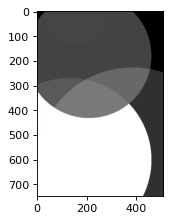

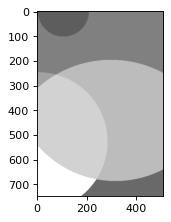

In [363]:
rpop=random_population(10, 4, genotype_len=5, gray=True)
print(MSE_objective_f(represent_individual(rpop[0])))
print(rpop[0])
print(represent_individual(rpop[0]).shape)
draw_individual(represent_individual(rpop[0]))
mutated=rpop[0].copy()
for i in range(100):
    mutated=mutate_X(mutated)
draw_individual(represent_individual(mutated))

In [245]:
def evaluate_individual(evals, i, X, f):
    evals[i]=f(represent_individual(X))

In [388]:
np.clip(random_population(10,8), 0.1, 0.5).shape

(10, 8, 7)

In [398]:
def es(
    objective_function, 
    chromosome_length,
    genotype_length,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
    number_of_offspring_per_parent=3, 
    mutation_scale=1e-1,
    max_chromosome_length=128,
    gray=False,
  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1,
    pararell=False
):

   # print(chromosome_length)
    best_solution = np.zeros((max_chromosome_length, genotype_length))
    best_solution_objective_value = np.inf

    
    log_objective_values = np.zeros((number_of_iterations, 4))
    log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
   # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions=random_population(population_size, chromosome_length, genotype_length, gray)
   # current_population_solutions[::2]=0.5
  #  current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values=np.ones(current_population_solutions.shape[0])
    if pararell:
        threads=[]
        for i in range(population_size):
            t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                          current_population_solutions[i], objective_function])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])
    #objective_function(current_population_solutions)
  #  print(current_population_objective_values)
    try:
        times_circles_were_added=1 # initial creation of population
        last_update_iter=0
        start_mutations_scale=mutation_scale
        for no_iter in progress_bar(range(number_of_iterations)):

            # selecting the parent indices by the roulette wheel method
            # MAXIMIZE
            #fitness_values = current_population_objective_values - current_population_objective_values.min()
            # MINIMIZE
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / population_size * np.ones(population_size)
            parent_indices = np.random.choice(population_size, number_of_parents, True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_list=[]
            for i in range(number_of_offspring_per_parent):
                children_list.append(current_population_solutions[parent_indices].copy())          
            children_population_solutions = np.vstack(children_list)
            
        #    for i in range(children_population_solutions.shape[0]):
         #       children_population_solutions[i]=mutate_X(children_population_solutions[i], 
          #                                                scale=mutation_scale)
            
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=mutate_X_thred, args=[children_population_solutions, i, 
                                                             mutation_scale])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                for i in range(children_population_solutions.shape[0]):
                    children_population_solutions[i]=mutate_X(children_population_solutions[i], 
                                                              scale=mutation_scale)
            #children_population_solutions=mutate_population(children_population_solutions,
            #                                               scale=mutation_scale)
            
            
            #np.empty((number_of_offspring, chromosome_length), dtype=Circle)
            #children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))

           # for i in range(number_of_offspring):
            #    children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
             #   children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

            # mutating the children population by adding random gaussian noise
          #  children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
           # children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

            # evaluating the objective function on the children population
            children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=evaluate_individual, args=[children_population_objective_values, i,
                                                                  children_population_solutions[i], objective_function])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                children_population_objective_values = [objective_function(represent_individual(X)) for X in children_population_solutions]

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
           # current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

            I = np.argsort(current_population_objective_values)#[::-1]
            current_population_solutions = current_population_solutions[I[:population_size], :]
        #    current_population_sigmas = current_population_sigmas[I[:population_size], :]
            current_population_objective_values = current_population_objective_values[I[:population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                best_solution = current_population_solutions[0, :]
                best_solution_objective_value = current_population_objective_values[0]

         #   print(no_iter, current_population_objective_values.min(), 
        #          current_population_objective_values.max(), 
         #         current_population_objective_values.mean(), 
        #          current_population_objective_values.std())
            log_objective_values[no_iter, :] = [current_population_objective_values.min(), 
                                                current_population_objective_values.max(),
                                                current_population_objective_values.mean(), 
                                                current_population_objective_values.std()]

           # print(log_best_solutions.shape, current_population_solutions.shape )
           # log_best_solutions[no_iter, :] = current_population_solutions[0, :]

           # log_best_sigmas[t, :] = current_population_sigmas[0, :]

            if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:
                
                log_best_solutions.append(current_population_solutions[0, :])
                print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                    log_objective_values[no_iter, 0], 
                                                                                    log_objective_values[no_iter, 2]))
                #draw_individual(represent_individual(best_solution), gray)
                save_individual_img(represent_individual(best_solution), gray, no_iter=no_iter)
                
                if no_iter-last_update_iter>=times_circles_were_added*400 and no_iter>2*log_frequency:
                    prev=np.mean(log_objective_values[no_iter-2*log_frequency:no_iter-log_frequency])
                    curr=np.mean(log_objective_values[no_iter-log_frequency:no_iter+1])
                    if (prev-curr)/prev < 0.005: # ADD CIRCLES
                        
                        last_update_iter=no_iter
                        times_circles_were_added+=1
                        best_solution_objective_value=np.inf
                        mutation_scale=start_mutations_scale/times_circles_were_added
                        
                        radius_scale=1/(2*times_circles_were_added)
                        if radius_scale<1/16:
                            radius_scale=1/16
                                
                        new_pop=random_population(population_size, chromosome_length, 
                                                  genotype_length, gray, 
                                                  max_radius_scale=radius_scale,
                                                  max_opacity_scale=0.5)
                        current_population_solutions=np.concatenate([current_population_solutions, new_pop], 
                                                                    axis=1)
                        print(f'Added more circles of radius_scale={radius_scale}, mutation scale={mutation_scale}.\n New population shape: {current_population_solutions.shape}')
                        
                        if pararell:
                            threads=[]
                            for i in range(population_size):
                                t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                                              current_population_solutions[i], objective_function])
                                t.start()
                                threads.append(t)
                            for t in threads:
                                t.join()
                        else:
                            current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])

        
    except KeyboardInterrupt:
        print('Interrupted')
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, current_population_solutions

  0%|                                                 | 0/30000 [00:00<?, ?it/s]

Iteration 0000 : best score = 7322.71670113, mean score = 15160.00809191.


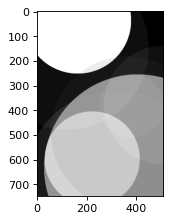

  0%|                                     | 100/30000 [00:28<2:21:25,  3.52it/s]

Iteration 0100 : best score = 2578.51509865, mean score = 2594.97718601.


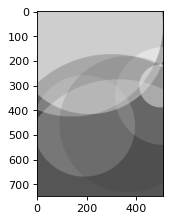

  1%|▏                                    | 200/30000 [00:57<2:22:16,  3.49it/s]

Iteration 0200 : best score = 2448.85459510, mean score = 2458.57099852.


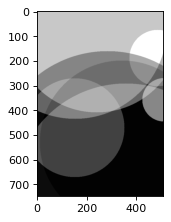

  1%|▎                                    | 300/30000 [01:26<2:20:53,  3.51it/s]

Iteration 0300 : best score = 2431.48154521, mean score = 2434.41720899.


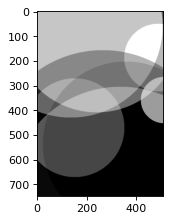

  1%|▍                                    | 400/30000 [01:54<2:19:27,  3.54it/s]

Iteration 0400 : best score = 2420.12084661, mean score = 2422.57809202.


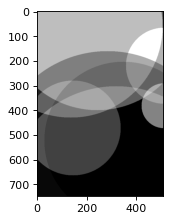

  2%|▌                                    | 500/30000 [02:23<2:19:07,  3.53it/s]

Iteration 0500 : best score = 2416.10728807, mean score = 2418.53639781.


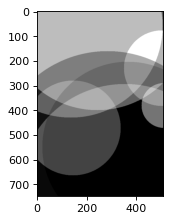

Added more circles of radius_scale=0.25, mutation scale=0.05.
 New population shape: (32, 16, 5)


  2%|▋                                    | 600/30000 [03:13<4:04:21,  2.01it/s]

Iteration 0600 : best score = 2084.21355695, mean score = 2088.30482972.


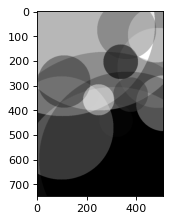

  2%|▊                                    | 700/30000 [04:03<4:10:26,  1.95it/s]

Iteration 0700 : best score = 1990.64856530, mean score = 2000.29921425.


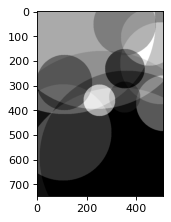

  3%|▉                                    | 800/30000 [04:53<4:02:07,  2.01it/s]

Iteration 0800 : best score = 1953.15896146, mean score = 1956.53853588.


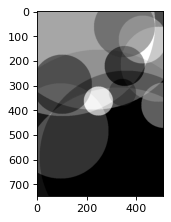

  3%|█                                    | 900/30000 [05:44<4:02:53,  2.00it/s]

Iteration 0900 : best score = 1936.10587264, mean score = 1939.54213781.


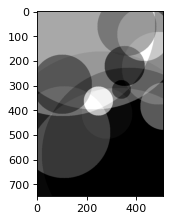

  3%|█▏                                  | 1000/30000 [06:34<4:01:29,  2.00it/s]

Iteration 1000 : best score = 1915.51764403, mean score = 1919.46666293.


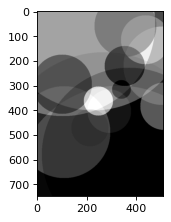

  4%|█▎                                  | 1100/30000 [07:24<4:08:43,  1.94it/s]

Iteration 1100 : best score = 1906.35998019, mean score = 1908.45562735.


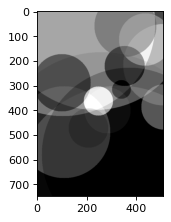

  4%|█▍                                  | 1200/30000 [08:15<3:59:14,  2.01it/s]

Iteration 1200 : best score = 1889.19345328, mean score = 1893.95341512.


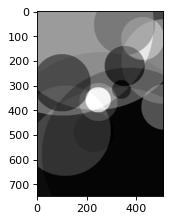

  4%|█▌                                  | 1300/30000 [09:05<3:57:59,  2.01it/s]

Iteration 1300 : best score = 1878.08083346, mean score = 1882.53712803.


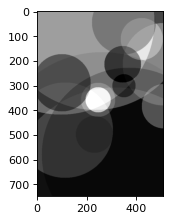

  5%|█▋                                  | 1400/30000 [09:54<3:57:39,  2.01it/s]

Iteration 1400 : best score = 1865.45565053, mean score = 1868.28710567.


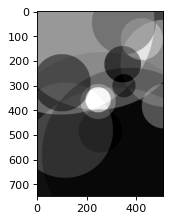

  5%|█▊                                  | 1500/30000 [10:44<3:56:26,  2.01it/s]

Iteration 1500 : best score = 1863.83091148, mean score = 1865.68216020.


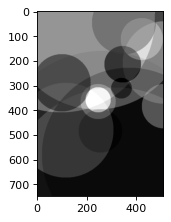

Added more circles of radius_scale=0.16666666666666666, mutation scale=0.03333333333333333.
 New population shape: (32, 24, 5)


  5%|█▉                                  | 1600/30000 [11:56<5:35:49,  1.41it/s]

Iteration 1600 : best score = 1728.72707687, mean score = 1734.85042029.


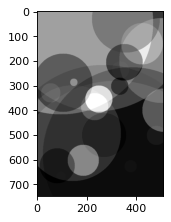

  6%|██                                  | 1700/30000 [13:07<5:35:03,  1.41it/s]

Iteration 1700 : best score = 1698.72618347, mean score = 1700.79390893.


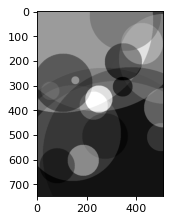

  6%|██▏                                 | 1800/30000 [14:18<5:34:24,  1.41it/s]

Iteration 1800 : best score = 1677.04184191, mean score = 1679.48639550.


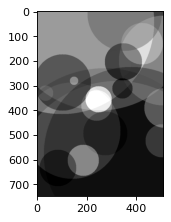

  6%|██▎                                 | 1900/30000 [15:30<5:32:46,  1.41it/s]

Iteration 1900 : best score = 1670.39940400, mean score = 1671.65964356.


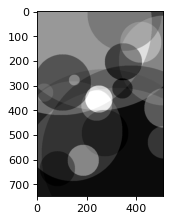

  7%|██▍                                 | 2000/30000 [16:41<5:31:55,  1.41it/s]

Iteration 2000 : best score = 1661.66500153, mean score = 1663.29341646.


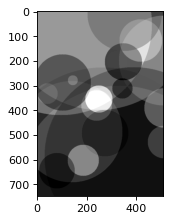

  7%|██▌                                 | 2100/30000 [17:52<5:31:45,  1.40it/s]

Iteration 2100 : best score = 1657.76708194, mean score = 1658.82300353.


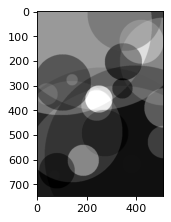

  7%|██▋                                 | 2200/30000 [19:04<5:29:49,  1.40it/s]

Iteration 2200 : best score = 1655.43674748, mean score = 1656.09547879.


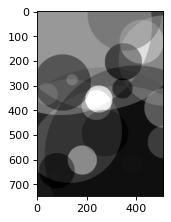

  8%|██▊                                 | 2300/30000 [20:15<5:28:08,  1.41it/s]

Iteration 2300 : best score = 1652.50625947, mean score = 1653.82705851.


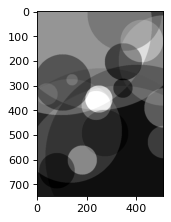

  8%|██▉                                 | 2400/30000 [21:26<5:27:16,  1.41it/s]

Iteration 2400 : best score = 1648.65672597, mean score = 1650.06032345.


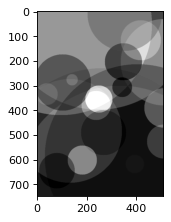

  8%|███                                 | 2500/30000 [22:37<5:25:15,  1.41it/s]

Iteration 2500 : best score = 1646.57227971, mean score = 1647.50902128.


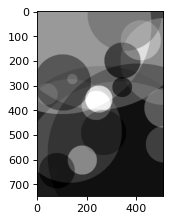

  9%|███                                 | 2600/30000 [23:49<5:25:13,  1.40it/s]

Iteration 2600 : best score = 1641.79477270, mean score = 1644.21725100.


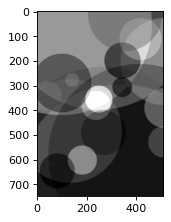

  9%|███▏                                | 2700/30000 [25:00<5:23:16,  1.41it/s]

Iteration 2700 : best score = 1634.56470153, mean score = 1636.01128678.


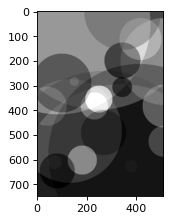

Added more circles of radius_scale=0.125, mutation scale=0.025.
 New population shape: (32, 32, 5)


  9%|███▎                                | 2800/30000 [26:33<6:58:37,  1.08it/s]

Iteration 2800 : best score = 1624.46280824, mean score = 1627.26944978.


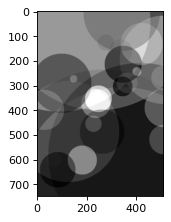

 10%|███▍                                | 2900/30000 [28:06<6:57:29,  1.08it/s]

Iteration 2900 : best score = 1608.55243751, mean score = 1610.71675071.


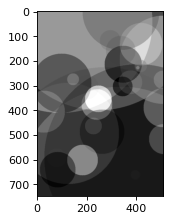

 10%|███▌                                | 3000/30000 [29:38<6:55:46,  1.08it/s]

Iteration 3000 : best score = 1594.91244428, mean score = 1599.76403866.


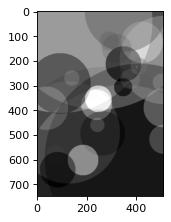

 10%|███▋                                | 3100/30000 [31:11<6:53:27,  1.08it/s]

Iteration 3100 : best score = 1583.92485527, mean score = 1585.12748011.


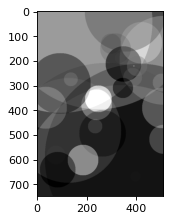

 11%|███▊                                | 3200/30000 [32:43<6:53:35,  1.08it/s]

Iteration 3200 : best score = 1577.06353597, mean score = 1578.16640524.


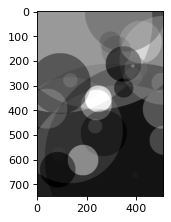

 11%|███▉                                | 3300/30000 [34:16<6:51:49,  1.08it/s]

Iteration 3300 : best score = 1568.95919831, mean score = 1569.89771170.


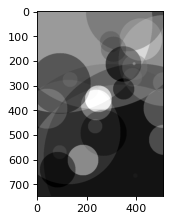

 11%|████                                | 3400/30000 [35:48<6:49:23,  1.08it/s]

Iteration 3400 : best score = 1562.33450459, mean score = 1563.37587840.


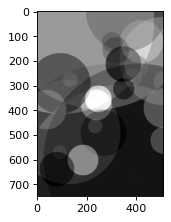

 12%|████▏                               | 3500/30000 [37:21<6:48:53,  1.08it/s]

Iteration 3500 : best score = 1557.19717682, mean score = 1557.69633744.


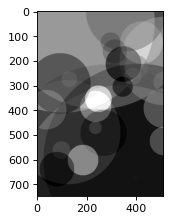

 12%|████▎                               | 3600/30000 [38:54<6:52:18,  1.07it/s]

Iteration 3600 : best score = 1553.40746156, mean score = 1554.39394881.


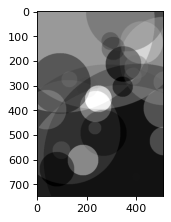

 12%|████▍                               | 3700/30000 [40:27<6:45:14,  1.08it/s]

Iteration 3700 : best score = 1550.57318415, mean score = 1551.19199674.


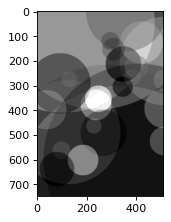

 13%|████▌                               | 3800/30000 [42:00<6:47:22,  1.07it/s]

Iteration 3800 : best score = 1547.42846247, mean score = 1547.93946283.


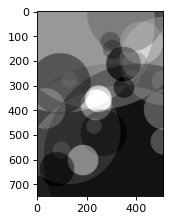

 13%|████▋                               | 3900/30000 [43:33<6:42:09,  1.08it/s]

Iteration 3900 : best score = 1544.99577412, mean score = 1546.12107488.


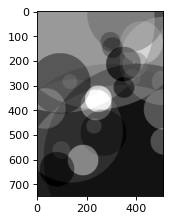

 13%|████▊                               | 4000/30000 [45:06<6:42:20,  1.08it/s]

Iteration 4000 : best score = 1543.41554540, mean score = 1543.99140536.


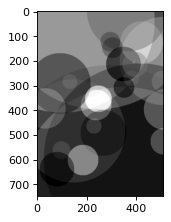

 14%|████▉                               | 4100/30000 [46:39<6:38:27,  1.08it/s]

Iteration 4100 : best score = 1539.82778987, mean score = 1541.48939706.


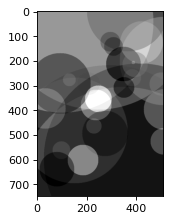

 14%|█████                               | 4200/30000 [48:12<6:37:13,  1.08it/s]

Iteration 4200 : best score = 1537.36363293, mean score = 1537.92374913.


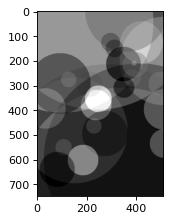

 14%|█████▏                              | 4300/30000 [49:44<6:36:33,  1.08it/s]

Iteration 4300 : best score = 1535.45233164, mean score = 1536.58649016.


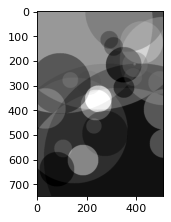

Added more circles of radius_scale=0.1, mutation scale=0.02.
 New population shape: (32, 40, 5)


 15%|█████▎                              | 4400/30000 [51:39<8:03:48,  1.13s/it]

Iteration 4400 : best score = 1552.73920511, mean score = 1554.16364740.


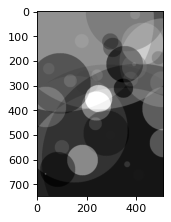

 15%|█████▍                              | 4500/30000 [53:33<8:02:10,  1.13s/it]

Iteration 4500 : best score = 1540.07798964, mean score = 1541.28112347.


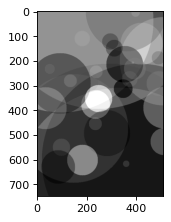

 15%|█████▌                              | 4600/30000 [55:27<8:15:39,  1.17s/it]

Iteration 4600 : best score = 1530.45771277, mean score = 1531.16348440.


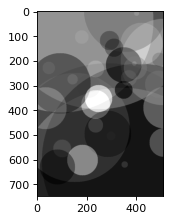

 16%|█████▋                              | 4700/30000 [57:22<7:58:44,  1.14s/it]

Iteration 4700 : best score = 1516.07065616, mean score = 1517.00749033.


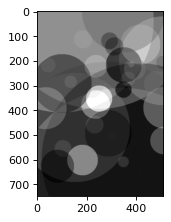

 16%|█████▊                              | 4800/30000 [59:15<7:57:24,  1.14s/it]

Iteration 4800 : best score = 1508.10756084, mean score = 1508.76412124.


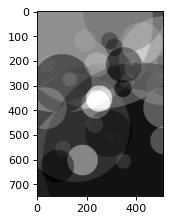

 16%|█████▌                            | 4900/30000 [1:01:09<7:54:13,  1.13s/it]

Iteration 4900 : best score = 1503.56273052, mean score = 1504.17534324.


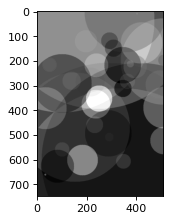

 17%|█████▋                            | 5000/30000 [1:03:03<7:52:44,  1.13s/it]

Iteration 5000 : best score = 1500.02443003, mean score = 1501.32073411.


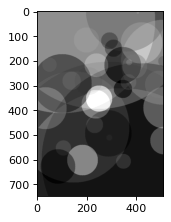

 17%|█████▊                            | 5100/30000 [1:04:57<7:53:04,  1.14s/it]

Iteration 5100 : best score = 1495.03173879, mean score = 1495.99535208.


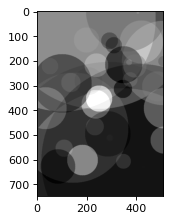

 17%|█████▉                            | 5200/30000 [1:06:51<7:49:05,  1.13s/it]

Iteration 5200 : best score = 1490.59984195, mean score = 1492.33318905.


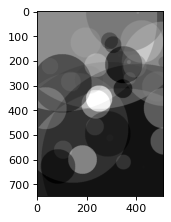

 18%|██████                            | 5300/30000 [1:08:45<7:48:38,  1.14s/it]

Iteration 5300 : best score = 1485.81207037, mean score = 1486.97619664.


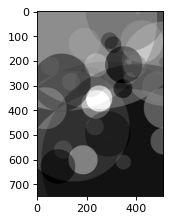

 18%|██████                            | 5400/30000 [1:10:39<7:45:59,  1.14s/it]

Iteration 5400 : best score = 1483.32671358, mean score = 1483.93562754.


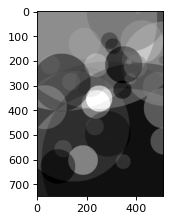

 18%|██████▏                           | 5500/30000 [1:12:33<7:49:55,  1.15s/it]

Iteration 5500 : best score = 1480.72961214, mean score = 1481.38660386.


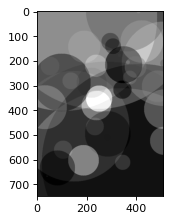

 19%|██████▎                           | 5600/30000 [1:14:26<7:41:03,  1.13s/it]

Iteration 5600 : best score = 1476.20410383, mean score = 1477.01974654.


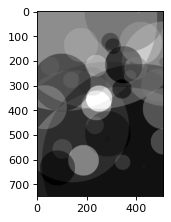

 19%|██████▍                           | 5700/30000 [1:16:20<7:40:46,  1.14s/it]

Iteration 5700 : best score = 1471.91274933, mean score = 1472.69278500.


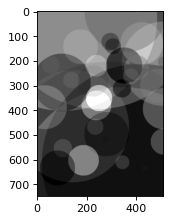

 19%|██████▌                           | 5800/30000 [1:18:14<7:39:46,  1.14s/it]

Iteration 5800 : best score = 1468.64126201, mean score = 1469.42321583.


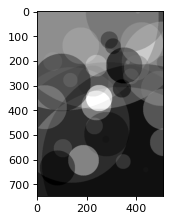

 20%|██████▋                           | 5900/30000 [1:20:08<7:36:52,  1.14s/it]

Iteration 5900 : best score = 1467.05924543, mean score = 1467.68671957.


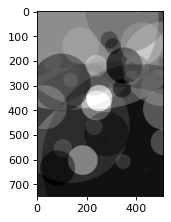

 20%|██████▊                           | 6000/30000 [1:22:02<7:41:47,  1.15s/it]

Iteration 6000 : best score = 1465.18774244, mean score = 1465.65322921.


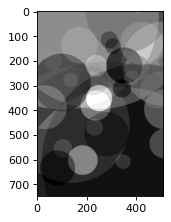

 20%|██████▉                           | 6100/30000 [1:23:56<7:32:18,  1.14s/it]

Iteration 6100 : best score = 1462.02253550, mean score = 1463.04294231.


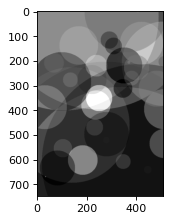

 21%|███████                           | 6200/30000 [1:25:50<7:31:08,  1.14s/it]

Iteration 6200 : best score = 1460.81244893, mean score = 1461.14826569.


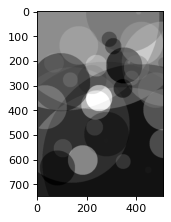

 21%|███████▏                          | 6300/30000 [1:27:43<7:29:05,  1.14s/it]

Iteration 6300 : best score = 1459.84218513, mean score = 1460.12537592.


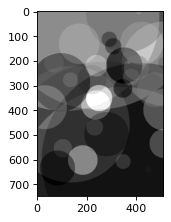

Added more circles of radius_scale=0.08333333333333333, mutation scale=0.016666666666666666.
 New population shape: (32, 48, 5)


 21%|███████▎                          | 6400/30000 [1:29:59<8:49:43,  1.35s/it]

Iteration 6400 : best score = 1467.24445456, mean score = 1468.48302685.


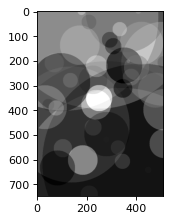

 22%|███████▎                          | 6500/30000 [1:32:15<8:49:18,  1.35s/it]

Iteration 6500 : best score = 1460.54112360, mean score = 1461.72337802.


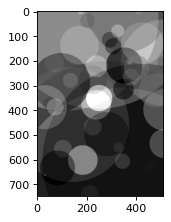

 22%|███████▍                          | 6600/30000 [1:34:30<8:45:44,  1.35s/it]

Iteration 6600 : best score = 1456.18691742, mean score = 1457.02533108.


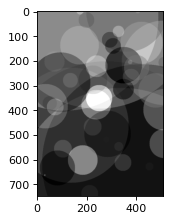

 22%|███████▌                          | 6700/30000 [1:36:46<8:50:12,  1.37s/it]

Iteration 6700 : best score = 1450.88631084, mean score = 1451.88524013.


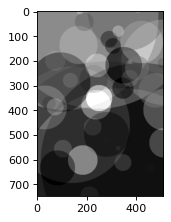

 23%|███████▋                          | 6800/30000 [1:39:01<8:42:11,  1.35s/it]

Iteration 6800 : best score = 1447.69996310, mean score = 1448.42746886.


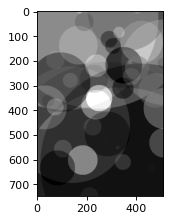

 23%|███████▊                          | 6900/30000 [1:41:16<8:39:16,  1.35s/it]

Iteration 6900 : best score = 1445.95662417, mean score = 1446.37301830.


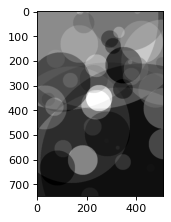

 23%|███████▉                          | 7000/30000 [1:43:31<8:37:35,  1.35s/it]

Iteration 7000 : best score = 1444.35786274, mean score = 1445.17361397.


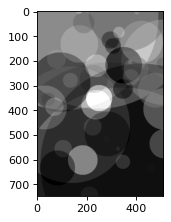

 24%|████████                          | 7100/30000 [1:45:46<8:37:21,  1.36s/it]

Iteration 7100 : best score = 1443.19277234, mean score = 1443.60321774.


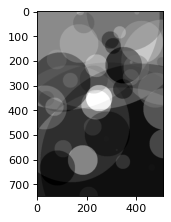

 24%|████████▏                         | 7200/30000 [1:48:01<8:31:13,  1.35s/it]

Iteration 7200 : best score = 1441.77144894, mean score = 1442.28743441.


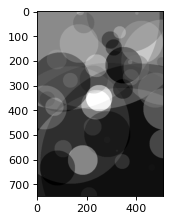

 24%|████████▎                         | 7300/30000 [1:50:16<8:29:41,  1.35s/it]

Iteration 7300 : best score = 1438.34520531, mean score = 1438.99678331.


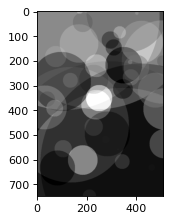

 25%|████████▍                         | 7400/30000 [1:52:31<8:28:08,  1.35s/it]

Iteration 7400 : best score = 1437.25014971, mean score = 1437.59133941.


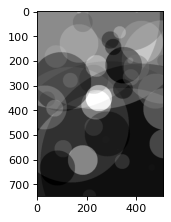

 25%|████████▌                         | 7500/30000 [1:54:47<8:25:52,  1.35s/it]

Iteration 7500 : best score = 1435.32506552, mean score = 1435.85806624.


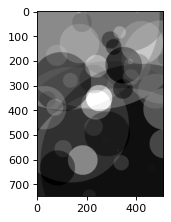

 25%|████████▌                         | 7600/30000 [1:57:02<8:24:29,  1.35s/it]

Iteration 7600 : best score = 1434.42482889, mean score = 1434.86516152.


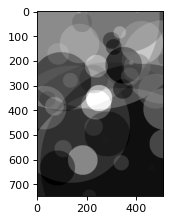

 26%|████████▋                         | 7700/30000 [1:59:17<8:21:55,  1.35s/it]

Iteration 7700 : best score = 1429.37884688, mean score = 1429.89808903.


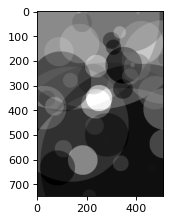

 26%|████████▊                         | 7800/30000 [2:01:32<8:19:05,  1.35s/it]

Iteration 7800 : best score = 1425.02470888, mean score = 1425.43162013.


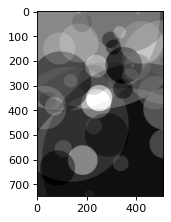

 26%|████████▉                         | 7900/30000 [2:03:47<8:17:10,  1.35s/it]

Iteration 7900 : best score = 1423.01595919, mean score = 1423.52598471.


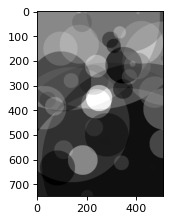

 27%|█████████                         | 8000/30000 [2:06:02<8:15:15,  1.35s/it]

Iteration 8000 : best score = 1421.77584439, mean score = 1422.06199350.


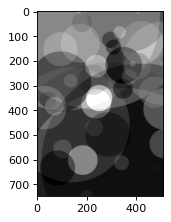

 27%|█████████▏                        | 8100/30000 [2:08:18<8:13:35,  1.35s/it]

Iteration 8100 : best score = 1420.12514275, mean score = 1420.93892622.


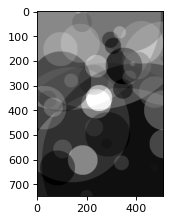

 27%|█████████▎                        | 8200/30000 [2:10:33<8:10:20,  1.35s/it]

Iteration 8200 : best score = 1418.77906217, mean score = 1419.28795693.


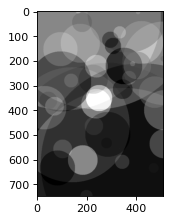

 28%|█████████▍                        | 8300/30000 [2:12:48<8:12:25,  1.36s/it]

Iteration 8300 : best score = 1417.94047878, mean score = 1418.24760730.


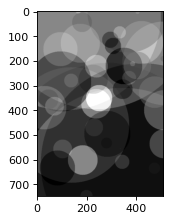

 28%|█████████▌                        | 8400/30000 [2:15:04<8:05:53,  1.35s/it]

Iteration 8400 : best score = 1416.59794441, mean score = 1416.87185333.


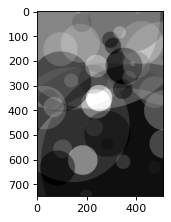

 28%|█████████▋                        | 8500/30000 [2:17:19<8:04:07,  1.35s/it]

Iteration 8500 : best score = 1414.20015862, mean score = 1414.81730442.


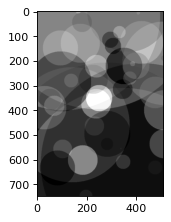

 29%|█████████▋                        | 8600/30000 [2:19:34<8:00:59,  1.35s/it]

Iteration 8600 : best score = 1413.38847475, mean score = 1413.57425910.


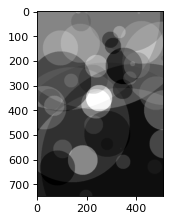

 29%|█████████▊                        | 8700/30000 [2:21:49<7:58:26,  1.35s/it]

Iteration 8700 : best score = 1412.08078778, mean score = 1412.57271451.


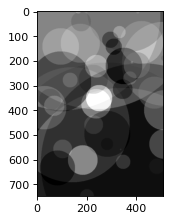

Added more circles of radius_scale=0.07142857142857142, mutation scale=0.014285714285714287.
 New population shape: (32, 56, 5)


 29%|█████████▉                        | 8800/30000 [2:24:27<9:11:12,  1.56s/it]

Iteration 8800 : best score = 1399.23899991, mean score = 1401.42217731.


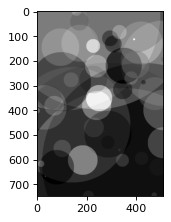

 30%|██████████                        | 8900/30000 [2:27:03<9:08:30,  1.56s/it]

Iteration 8900 : best score = 1389.83724681, mean score = 1390.61673089.


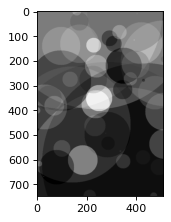

 30%|██████████▏                       | 9000/30000 [2:29:39<9:06:16,  1.56s/it]

Iteration 9000 : best score = 1381.87846078, mean score = 1382.48672602.


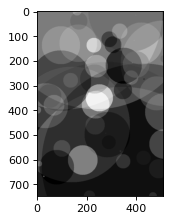

 30%|██████████▎                       | 9100/30000 [2:32:15<9:04:46,  1.56s/it]

Iteration 9100 : best score = 1378.20517992, mean score = 1378.80337580.


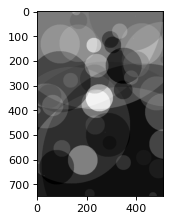

 31%|██████████▍                       | 9200/30000 [2:34:52<9:00:11,  1.56s/it]

Iteration 9200 : best score = 1374.47210901, mean score = 1374.84293373.


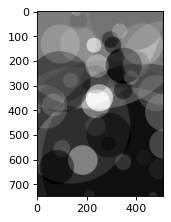

 31%|██████████▌                       | 9300/30000 [2:37:28<8:58:46,  1.56s/it]

Iteration 9300 : best score = 1371.71460272, mean score = 1372.24433142.


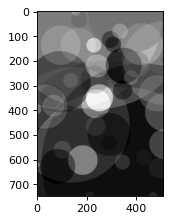

 31%|██████████▋                       | 9400/30000 [2:40:04<8:57:01,  1.56s/it]

Iteration 9400 : best score = 1367.71312498, mean score = 1368.27292839.


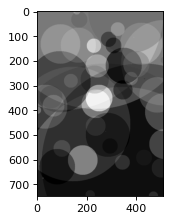

 32%|██████████▊                       | 9500/30000 [2:42:40<8:54:20,  1.56s/it]

Iteration 9500 : best score = 1365.49895876, mean score = 1365.78037492.


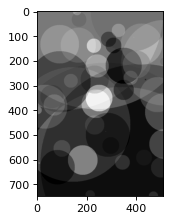

 32%|██████████▉                       | 9600/30000 [2:45:16<8:49:57,  1.56s/it]

Iteration 9600 : best score = 1363.53033308, mean score = 1364.04373938.


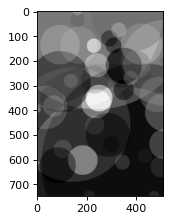

 32%|██████████▉                       | 9700/30000 [2:47:52<8:47:06,  1.56s/it]

Iteration 9700 : best score = 1361.50417615, mean score = 1362.10601983.


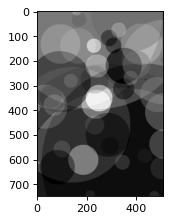

 33%|███████████                       | 9800/30000 [2:50:28<8:44:27,  1.56s/it]

Iteration 9800 : best score = 1358.71548120, mean score = 1359.80383635.


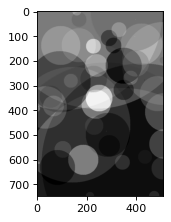

 33%|███████████▏                      | 9900/30000 [2:53:04<8:42:34,  1.56s/it]

Iteration 9900 : best score = 1356.00660593, mean score = 1356.47691876.


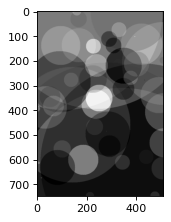

 33%|███████████                      | 10000/30000 [2:55:40<8:39:40,  1.56s/it]

Iteration 10000 : best score = 1354.21993834, mean score = 1354.80586574.


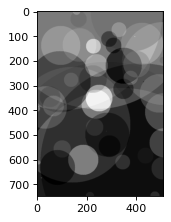

 34%|███████████                      | 10100/30000 [2:58:16<8:36:14,  1.56s/it]

Iteration 10100 : best score = 1351.96836849, mean score = 1352.20784834.


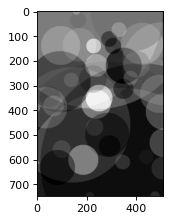

 34%|███████████▏                     | 10200/30000 [3:00:52<8:32:59,  1.55s/it]

Iteration 10200 : best score = 1350.65376051, mean score = 1351.16809135.


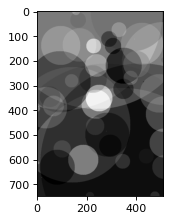

 34%|███████████▎                     | 10300/30000 [3:03:28<8:31:27,  1.56s/it]

Iteration 10300 : best score = 1349.65542971, mean score = 1349.87632030.


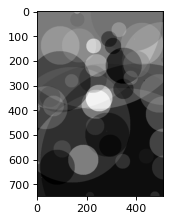

 35%|███████████▍                     | 10400/30000 [3:06:04<8:30:46,  1.56s/it]

Iteration 10400 : best score = 1347.97729714, mean score = 1348.30532604.


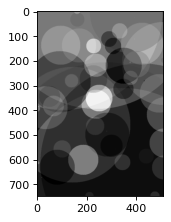

 35%|███████████▌                     | 10500/30000 [3:08:41<8:27:05,  1.56s/it]

Iteration 10500 : best score = 1347.07650807, mean score = 1347.64431542.


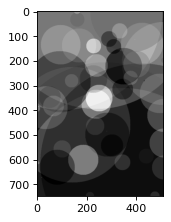

 35%|███████████▋                     | 10600/30000 [3:11:17<8:24:13,  1.56s/it]

Iteration 10600 : best score = 1345.74249465, mean score = 1346.21937189.


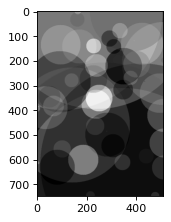

 36%|███████████▊                     | 10700/30000 [3:13:53<8:22:07,  1.56s/it]

Iteration 10700 : best score = 1344.75929055, mean score = 1345.13805092.


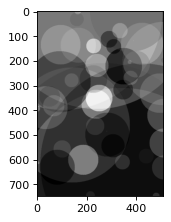

 36%|███████████▉                     | 10800/30000 [3:16:29<8:18:38,  1.56s/it]

Iteration 10800 : best score = 1344.18208791, mean score = 1344.65478610.


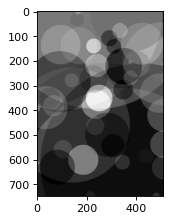

 36%|███████████▉                     | 10900/30000 [3:19:05<8:15:51,  1.56s/it]

Iteration 10900 : best score = 1342.47551909, mean score = 1342.87986260.


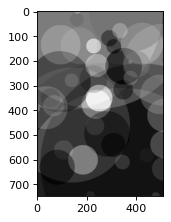

 37%|████████████                     | 11000/30000 [3:21:41<8:13:26,  1.56s/it]

Iteration 11000 : best score = 1340.97230696, mean score = 1341.72271234.


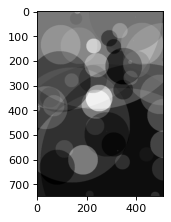

 37%|████████████▏                    | 11100/30000 [3:24:18<8:12:38,  1.56s/it]

Iteration 11100 : best score = 1340.48225842, mean score = 1340.72180141.


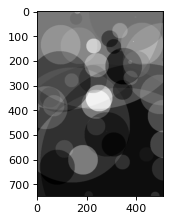

 37%|████████████▎                    | 11200/30000 [3:26:54<8:09:00,  1.56s/it]

Iteration 11200 : best score = 1340.02350602, mean score = 1340.26293902.


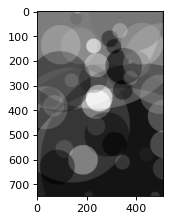

 38%|████████████▍                    | 11300/30000 [3:29:30<8:05:38,  1.56s/it]

Iteration 11300 : best score = 1338.88114398, mean score = 1339.33872669.


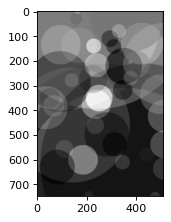

 38%|████████████▌                    | 11400/30000 [3:32:06<8:04:01,  1.56s/it]

Iteration 11400 : best score = 1338.12184768, mean score = 1338.36221842.


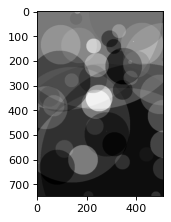

 38%|████████████▋                    | 11500/30000 [3:34:42<8:00:15,  1.56s/it]

Iteration 11500 : best score = 1337.73625216, mean score = 1338.02015143.


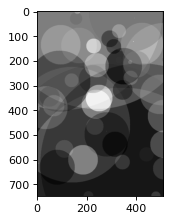

Added more circles of radius_scale=0.0625, mutation scale=0.0125.
 New population shape: (32, 64, 5)


 39%|████████████▊                    | 11600/30000 [3:37:41<9:02:15,  1.77s/it]

Iteration 11600 : best score = 1337.96264458, mean score = 1338.52474927.


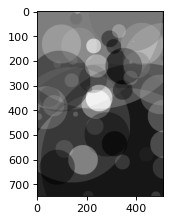

 39%|████████████▊                    | 11700/30000 [3:40:38<8:59:25,  1.77s/it]

Iteration 11700 : best score = 1336.64702308, mean score = 1336.95132881.


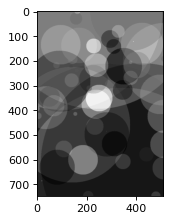

 39%|████████████▉                    | 11800/30000 [3:43:35<8:56:35,  1.77s/it]

Iteration 11800 : best score = 1335.84397745, mean score = 1336.32316492.


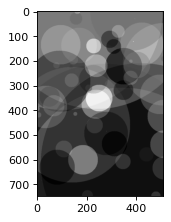

 40%|█████████████                    | 11900/30000 [3:46:32<8:53:23,  1.77s/it]

Iteration 11900 : best score = 1334.83427201, mean score = 1335.14049532.


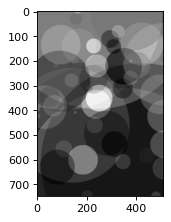

 40%|█████████████▏                   | 12000/30000 [3:49:29<8:50:38,  1.77s/it]

Iteration 12000 : best score = 1333.82241708, mean score = 1334.22627724.


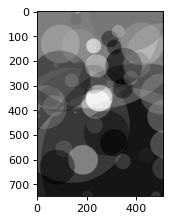

 40%|█████████████▎                   | 12100/30000 [3:52:26<8:47:43,  1.77s/it]

Iteration 12100 : best score = 1332.84628744, mean score = 1333.18864382.


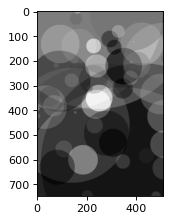

 41%|█████████████▍                   | 12200/30000 [3:55:23<8:44:24,  1.77s/it]

Iteration 12200 : best score = 1332.02939189, mean score = 1332.24720859.


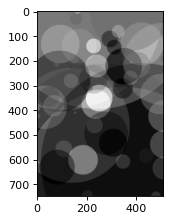

 41%|█████████████▌                   | 12300/30000 [3:58:21<8:41:45,  1.77s/it]

Iteration 12300 : best score = 1331.86071667, mean score = 1331.91570546.


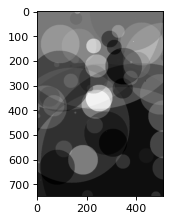

 41%|█████████████▋                   | 12400/30000 [4:01:18<8:39:26,  1.77s/it]

Iteration 12400 : best score = 1331.46336668, mean score = 1331.55391915.


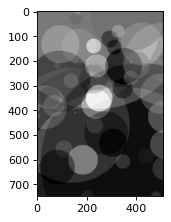

 42%|█████████████▊                   | 12500/30000 [4:04:15<8:38:22,  1.78s/it]

Iteration 12500 : best score = 1330.85274887, mean score = 1331.22782954.


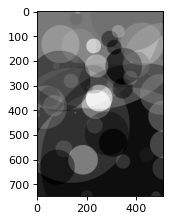

 42%|█████████████▊                   | 12600/30000 [4:07:12<8:32:37,  1.77s/it]

Iteration 12600 : best score = 1330.46094203, mean score = 1330.69731376.


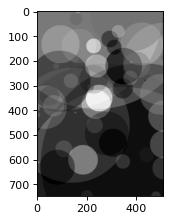

 42%|█████████████▉                   | 12700/30000 [4:10:09<8:30:27,  1.77s/it]

Iteration 12700 : best score = 1329.83522499, mean score = 1330.07404088.


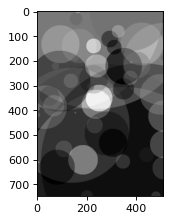

 43%|██████████████                   | 12800/30000 [4:13:07<8:27:57,  1.77s/it]

Iteration 12800 : best score = 1329.43147025, mean score = 1329.62757065.


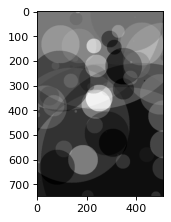

 43%|██████████████▏                  | 12900/30000 [4:16:04<8:26:10,  1.78s/it]

Iteration 12900 : best score = 1329.10787386, mean score = 1329.24824050.


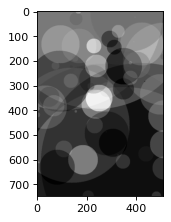

 43%|██████████████▎                  | 13000/30000 [4:19:02<8:22:12,  1.77s/it]

Iteration 13000 : best score = 1328.74964837, mean score = 1328.94179586.


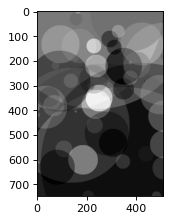

 44%|██████████████▍                  | 13100/30000 [4:21:59<8:18:05,  1.77s/it]

Iteration 13100 : best score = 1328.30208384, mean score = 1328.60205817.


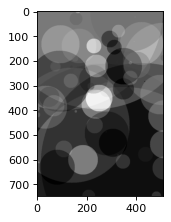

 44%|██████████████▌                  | 13200/30000 [4:24:56<8:14:42,  1.77s/it]

Iteration 13200 : best score = 1328.10480749, mean score = 1328.28846789.


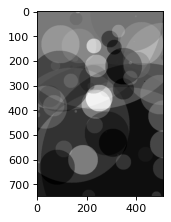

 44%|██████████████▋                  | 13300/30000 [4:27:54<8:12:13,  1.77s/it]

Iteration 13300 : best score = 1327.73679575, mean score = 1327.90548498.


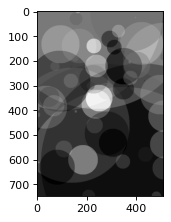

 45%|██████████████▋                  | 13400/30000 [4:30:51<8:09:40,  1.77s/it]

Iteration 13400 : best score = 1327.70445013, mean score = 1327.77028467.


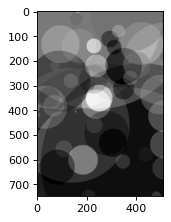

 45%|██████████████▊                  | 13500/30000 [4:33:48<8:06:12,  1.77s/it]

Iteration 13500 : best score = 1327.49553324, mean score = 1327.64759648.


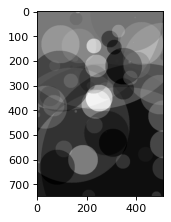

 45%|██████████████▉                  | 13600/30000 [4:36:45<8:03:24,  1.77s/it]

Iteration 13600 : best score = 1327.26458190, mean score = 1327.38464315.


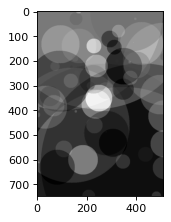

 46%|███████████████                  | 13700/30000 [4:39:43<8:00:21,  1.77s/it]

Iteration 13700 : best score = 1327.06734780, mean score = 1327.19095544.


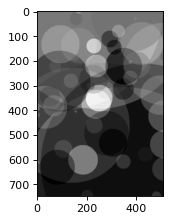

 46%|███████████████▏                 | 13800/30000 [4:42:40<7:58:35,  1.77s/it]

Iteration 13800 : best score = 1326.77526627, mean score = 1326.96952814.


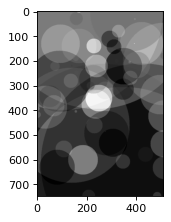

 46%|███████████████▎                 | 13900/30000 [4:45:37<7:55:03,  1.77s/it]

Iteration 13900 : best score = 1326.46822734, mean score = 1326.66006632.


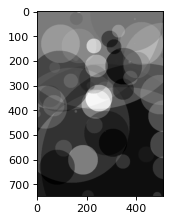

 47%|███████████████▍                 | 14000/30000 [4:48:34<7:51:23,  1.77s/it]

Iteration 14000 : best score = 1326.25472001, mean score = 1326.46965034.


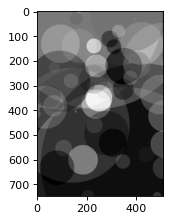

 47%|███████████████▌                 | 14100/30000 [4:51:31<7:48:33,  1.77s/it]

Iteration 14100 : best score = 1325.98709488, mean score = 1326.07808588.


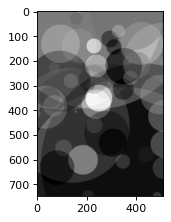

 47%|███████████████▌                 | 14200/30000 [4:54:29<7:46:25,  1.77s/it]

Iteration 14200 : best score = 1325.64949262, mean score = 1325.84378748.


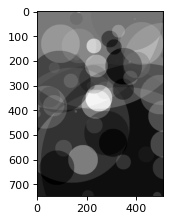

 48%|███████████████▋                 | 14300/30000 [4:57:26<7:43:18,  1.77s/it]

Iteration 14300 : best score = 1325.43481146, mean score = 1325.56743642.


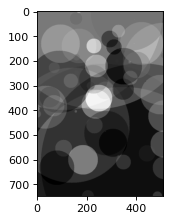

 48%|███████████████▊                 | 14400/30000 [5:00:24<7:41:08,  1.77s/it]

Iteration 14400 : best score = 1325.09628111, mean score = 1325.35495792.


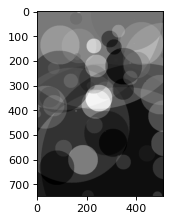

 48%|███████████████▉                 | 14500/30000 [5:03:21<7:37:36,  1.77s/it]

Iteration 14500 : best score = 1324.49915010, mean score = 1324.82649587.


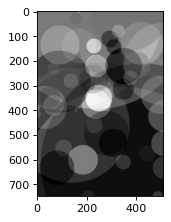

 49%|████████████████                 | 14600/30000 [5:06:18<7:34:46,  1.77s/it]

Iteration 14600 : best score = 1323.52051864, mean score = 1323.83456854.


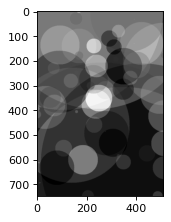

 49%|████████████████▏                | 14700/30000 [5:09:15<7:31:46,  1.77s/it]

Iteration 14700 : best score = 1322.19667805, mean score = 1322.49041501.


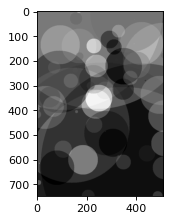

Added more circles of radius_scale=0.0625, mutation scale=0.011111111111111112.
 New population shape: (32, 72, 5)


 49%|████████████████▎                | 14800/30000 [5:12:35<8:22:10,  1.98s/it]

Iteration 14800 : best score = 1331.49382218, mean score = 1332.11498114.


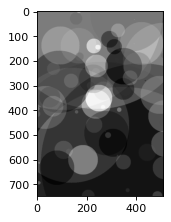

 50%|████████████████▍                | 14900/30000 [5:15:53<8:17:30,  1.98s/it]

Iteration 14900 : best score = 1327.43120920, mean score = 1328.41605357.


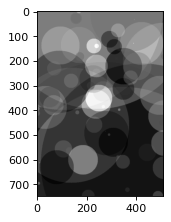

 50%|████████████████▌                | 15000/30000 [5:19:12<8:15:24,  1.98s/it]

Iteration 15000 : best score = 1324.68177616, mean score = 1325.59516777.


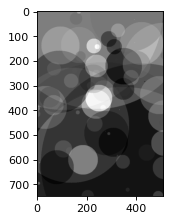

 50%|████████████████▌                | 15100/30000 [5:22:30<8:12:32,  1.98s/it]

Iteration 15100 : best score = 1323.21752681, mean score = 1323.53418126.


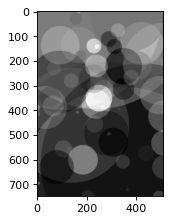

 51%|████████████████▋                | 15200/30000 [5:25:49<8:07:52,  1.98s/it]

Iteration 15200 : best score = 1321.97135510, mean score = 1322.30070752.


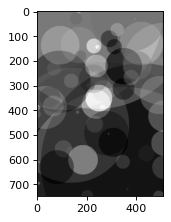

 51%|████████████████▊                | 15300/30000 [5:29:07<8:05:30,  1.98s/it]

Iteration 15300 : best score = 1321.15710802, mean score = 1321.52514257.


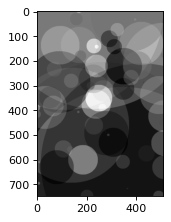

 51%|████████████████▉                | 15400/30000 [5:32:25<8:02:29,  1.98s/it]

Iteration 15400 : best score = 1319.31964996, mean score = 1319.90402510.


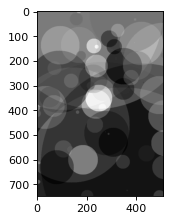

 52%|█████████████████                | 15500/30000 [5:35:44<7:58:20,  1.98s/it]

Iteration 15500 : best score = 1318.30559913, mean score = 1318.77151872.


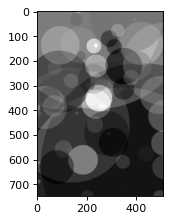

 52%|█████████████████▏               | 15600/30000 [5:39:02<7:54:41,  1.98s/it]

Iteration 15600 : best score = 1317.45876003, mean score = 1317.87386186.


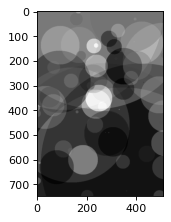

 52%|█████████████████▎               | 15700/30000 [5:42:21<7:52:43,  1.98s/it]

Iteration 15700 : best score = 1316.65525902, mean score = 1316.91838621.


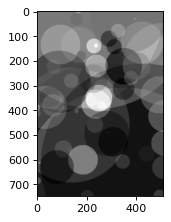

 53%|█████████████████▍               | 15800/30000 [5:45:39<7:48:46,  1.98s/it]

Iteration 15800 : best score = 1315.93615766, mean score = 1316.24278042.


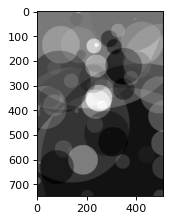

 53%|█████████████████▍               | 15900/30000 [5:48:57<7:45:10,  1.98s/it]

Iteration 15900 : best score = 1314.41921500, mean score = 1315.05310970.


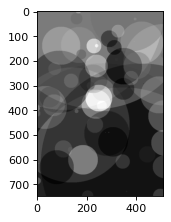

 53%|█████████████████▌               | 16000/30000 [5:52:15<7:42:22,  1.98s/it]

Iteration 16000 : best score = 1314.29158681, mean score = 1314.38087263.


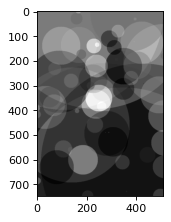

 54%|█████████████████▋               | 16100/30000 [5:55:34<7:38:51,  1.98s/it]

Iteration 16100 : best score = 1313.35182531, mean score = 1313.60038511.


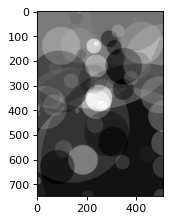

 54%|█████████████████▊               | 16200/30000 [5:58:52<7:34:51,  1.98s/it]

Iteration 16200 : best score = 1313.02295395, mean score = 1313.11689291.


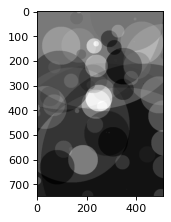

 54%|█████████████████▉               | 16300/30000 [6:02:10<7:32:40,  1.98s/it]

Iteration 16300 : best score = 1311.96009585, mean score = 1312.51621387.


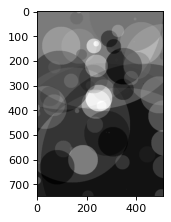

 55%|██████████████████               | 16400/30000 [6:05:28<7:28:38,  1.98s/it]

Iteration 16400 : best score = 1311.27304270, mean score = 1311.55261340.


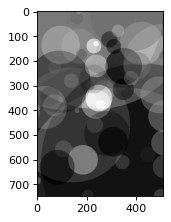

 55%|██████████████████▏              | 16500/30000 [6:08:47<7:26:36,  1.98s/it]

Iteration 16500 : best score = 1311.02386269, mean score = 1311.11543297.


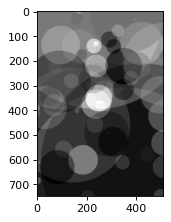

 55%|██████████████████▎              | 16600/30000 [6:12:05<7:24:00,  1.99s/it]

Iteration 16600 : best score = 1310.38174488, mean score = 1310.56499788.


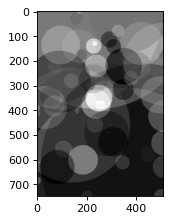

 56%|██████████████████▎              | 16700/30000 [6:15:23<7:18:36,  1.98s/it]

Iteration 16700 : best score = 1310.15491767, mean score = 1310.25133626.


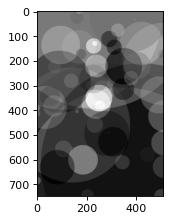

 56%|██████████████████▍              | 16800/30000 [6:18:42<7:16:02,  1.98s/it]

Iteration 16800 : best score = 1309.83583298, mean score = 1309.97496079.


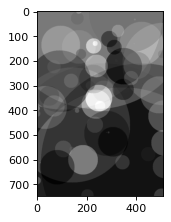

 56%|██████████████████▌              | 16900/30000 [6:22:00<7:11:47,  1.98s/it]

Iteration 16900 : best score = 1309.20904327, mean score = 1309.37041783.


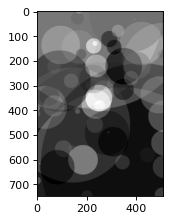

 57%|██████████████████▋              | 17000/30000 [6:25:18<7:09:05,  1.98s/it]

Iteration 17000 : best score = 1308.68732002, mean score = 1308.84144121.


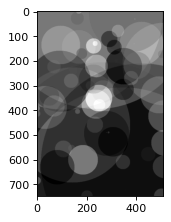

 57%|██████████████████▊              | 17100/30000 [6:28:36<7:05:46,  1.98s/it]

Iteration 17100 : best score = 1308.11324648, mean score = 1308.28113661.


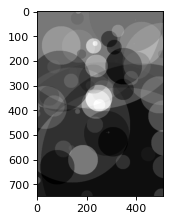

 57%|██████████████████▉              | 17200/30000 [6:31:55<7:02:37,  1.98s/it]

Iteration 17200 : best score = 1307.79978755, mean score = 1307.90352590.


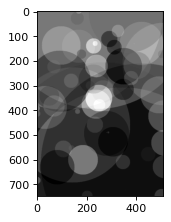

 58%|███████████████████              | 17300/30000 [6:35:13<6:58:51,  1.98s/it]

Iteration 17300 : best score = 1307.56496535, mean score = 1307.71886371.


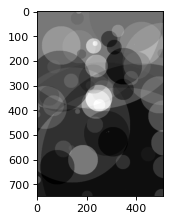

 58%|███████████████████▏             | 17400/30000 [6:38:31<6:55:31,  1.98s/it]

Iteration 17400 : best score = 1307.14363745, mean score = 1307.44497299.


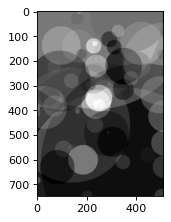

 58%|███████████████████▎             | 17500/30000 [6:41:49<6:52:00,  1.98s/it]

Iteration 17500 : best score = 1306.82651693, mean score = 1307.10629272.


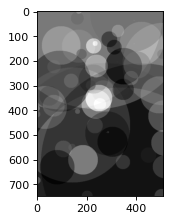

 59%|███████████████████▎             | 17600/30000 [6:45:07<6:48:55,  1.98s/it]

Iteration 17600 : best score = 1306.69668600, mean score = 1306.78479217.


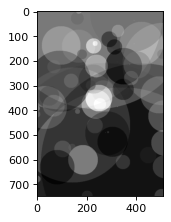

 59%|███████████████████▍             | 17700/30000 [6:48:25<6:45:38,  1.98s/it]

Iteration 17700 : best score = 1306.34523649, mean score = 1306.49565115.


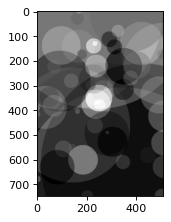

 59%|███████████████████▌             | 17800/30000 [6:51:44<6:42:23,  1.98s/it]

Iteration 17800 : best score = 1306.00598310, mean score = 1306.14962717.


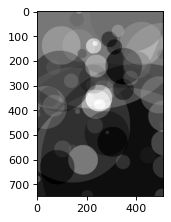

 60%|███████████████████▋             | 17900/30000 [6:55:02<6:38:51,  1.98s/it]

Iteration 17900 : best score = 1305.85377860, mean score = 1305.92753111.


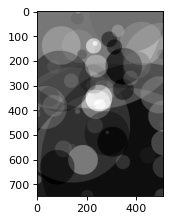

 60%|███████████████████▊             | 18000/30000 [6:58:20<6:37:26,  1.99s/it]

Iteration 18000 : best score = 1305.58185831, mean score = 1305.68285847.


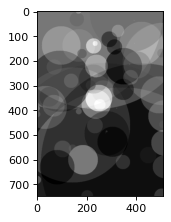

 60%|███████████████████▉             | 18100/30000 [7:01:38<6:32:16,  1.98s/it]

Iteration 18100 : best score = 1305.41285800, mean score = 1305.51816053.


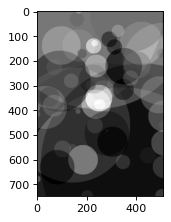

 61%|████████████████████             | 18200/30000 [7:04:56<6:29:16,  1.98s/it]

Iteration 18200 : best score = 1304.97097209, mean score = 1305.23582790.


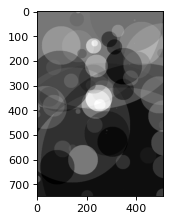

 61%|████████████████████▏            | 18300/30000 [7:08:14<6:26:11,  1.98s/it]

Iteration 18300 : best score = 1304.91236297, mean score = 1304.97245345.


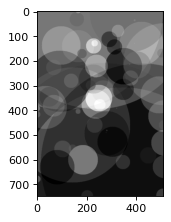

Added more circles of radius_scale=0.0625, mutation scale=0.01.
 New population shape: (32, 80, 5)


 61%|████████████████████▏            | 18400/30000 [7:11:56<7:03:05,  2.19s/it]

Iteration 18400 : best score = 1316.91941799, mean score = 1318.00291292.


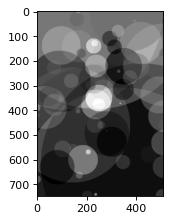

 62%|████████████████████▎            | 18500/30000 [7:15:35<6:59:37,  2.19s/it]

Iteration 18500 : best score = 1314.27801102, mean score = 1314.85713292.


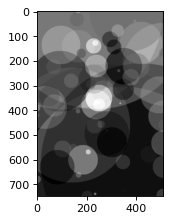

 62%|████████████████████▍            | 18600/30000 [7:19:14<6:56:58,  2.19s/it]

Iteration 18600 : best score = 1311.60978554, mean score = 1312.02192187.


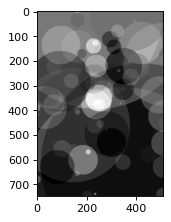

 62%|████████████████████▌            | 18700/30000 [7:22:54<6:52:46,  2.19s/it]

Iteration 18700 : best score = 1310.44542003, mean score = 1310.81265104.


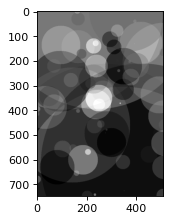

 63%|████████████████████▋            | 18800/30000 [7:26:33<6:49:20,  2.19s/it]

Iteration 18800 : best score = 1308.71216326, mean score = 1309.07521634.


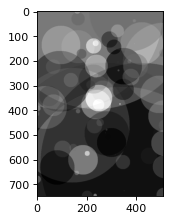

 63%|████████████████████▊            | 18900/30000 [7:30:13<6:46:55,  2.20s/it]

Iteration 18900 : best score = 1307.85066537, mean score = 1308.15189504.


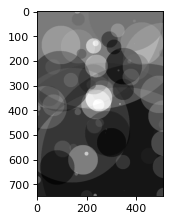

 63%|████████████████████▉            | 19000/30000 [7:33:52<6:42:15,  2.19s/it]

Iteration 19000 : best score = 1306.97249591, mean score = 1307.16814987.


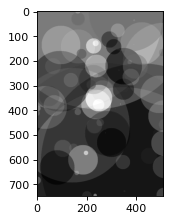

 64%|█████████████████████            | 19100/30000 [7:37:32<6:38:09,  2.19s/it]

Iteration 19100 : best score = 1305.65241501, mean score = 1306.06592299.


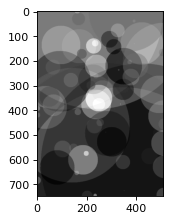

 64%|█████████████████████            | 19200/30000 [7:41:12<6:34:37,  2.19s/it]

Iteration 19200 : best score = 1305.12052183, mean score = 1305.25971813.


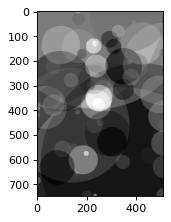

 64%|█████████████████████▏           | 19300/30000 [7:44:51<6:30:42,  2.19s/it]

Iteration 19300 : best score = 1303.76307033, mean score = 1304.33597413.


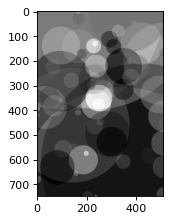

 65%|█████████████████████▎           | 19400/30000 [7:48:30<6:26:02,  2.19s/it]

Iteration 19400 : best score = 1303.24672601, mean score = 1303.39031957.


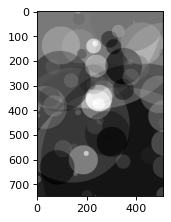

 65%|█████████████████████▍           | 19500/30000 [7:52:09<6:26:06,  2.21s/it]

Iteration 19500 : best score = 1302.64178831, mean score = 1302.77108282.


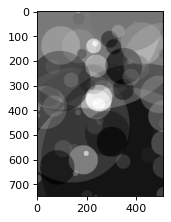

 65%|█████████████████████▌           | 19600/30000 [7:55:49<6:19:38,  2.19s/it]

Iteration 19600 : best score = 1301.82581723, mean score = 1302.19008038.


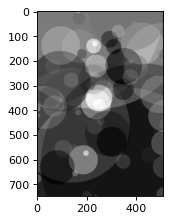

 66%|█████████████████████▋           | 19700/30000 [7:59:28<6:15:41,  2.19s/it]

Iteration 19700 : best score = 1301.45605920, mean score = 1301.71450484.


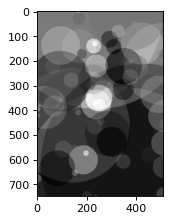

 66%|█████████████████████▊           | 19800/30000 [8:03:07<6:12:36,  2.19s/it]

Iteration 19800 : best score = 1300.91373263, mean score = 1301.16015662.


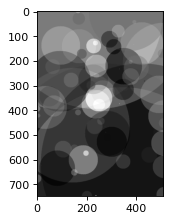

 66%|█████████████████████▉           | 19900/30000 [8:06:47<6:08:32,  2.19s/it]

Iteration 19900 : best score = 1300.33695398, mean score = 1300.62946113.


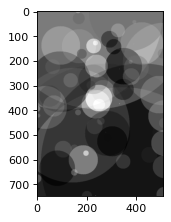

 67%|██████████████████████           | 20000/30000 [8:10:26<6:05:27,  2.19s/it]

Iteration 20000 : best score = 1298.39251576, mean score = 1298.71785080.


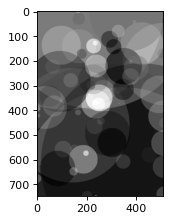

 67%|██████████████████████           | 20100/30000 [8:14:05<6:02:59,  2.20s/it]

Iteration 20100 : best score = 1297.49932620, mean score = 1298.11142782.


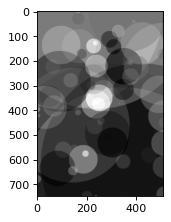

 67%|██████████████████████▏          | 20200/30000 [8:17:45<5:57:33,  2.19s/it]

Iteration 20200 : best score = 1296.70681838, mean score = 1296.91843774.


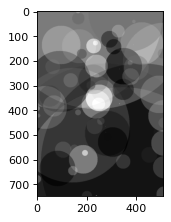

 68%|██████████████████████▎          | 20300/30000 [8:21:24<5:53:54,  2.19s/it]

Iteration 20300 : best score = 1296.02403727, mean score = 1296.30567445.


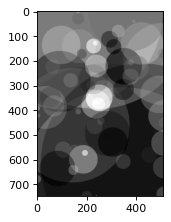

 68%|██████████████████████▍          | 20400/30000 [8:25:03<5:50:15,  2.19s/it]

Iteration 20400 : best score = 1294.85894252, mean score = 1295.09057719.


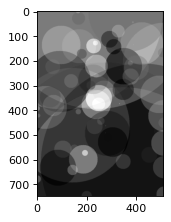

 68%|██████████████████████▌          | 20500/30000 [8:28:43<5:47:41,  2.20s/it]

Iteration 20500 : best score = 1294.55525036, mean score = 1294.67681331.


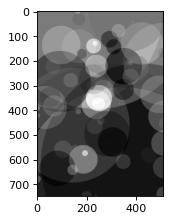

 69%|██████████████████████▋          | 20600/30000 [8:32:22<5:42:59,  2.19s/it]

Iteration 20600 : best score = 1294.08032588, mean score = 1294.30583666.


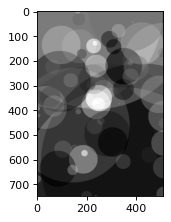

 69%|██████████████████████▊          | 20700/30000 [8:36:01<5:39:35,  2.19s/it]

Iteration 20700 : best score = 1293.08074283, mean score = 1293.31784661.


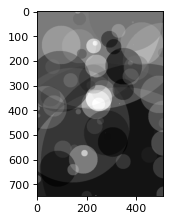

 69%|██████████████████████▉          | 20800/30000 [8:39:41<5:35:40,  2.19s/it]

Iteration 20800 : best score = 1292.73991933, mean score = 1292.84986939.


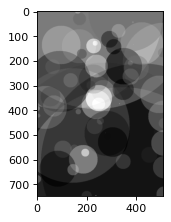

 70%|██████████████████████▉          | 20900/30000 [8:43:20<5:32:23,  2.19s/it]

Iteration 20900 : best score = 1292.03213314, mean score = 1292.22563927.


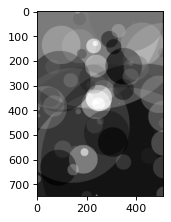

 70%|███████████████████████          | 21000/30000 [8:47:00<5:28:28,  2.19s/it]

Iteration 21000 : best score = 1290.90947913, mean score = 1291.08292857.


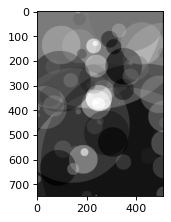

 70%|███████████████████████▏         | 21100/30000 [8:50:39<5:24:45,  2.19s/it]

Iteration 21100 : best score = 1289.37972414, mean score = 1289.57007792.


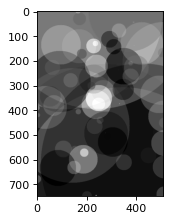

 71%|███████████████████████▎         | 21200/30000 [8:54:18<5:21:54,  2.19s/it]

Iteration 21200 : best score = 1288.42507951, mean score = 1288.52392099.


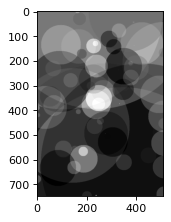

 71%|███████████████████████▍         | 21300/30000 [8:57:57<5:19:48,  2.21s/it]

Iteration 21300 : best score = 1287.60149074, mean score = 1287.87003240.


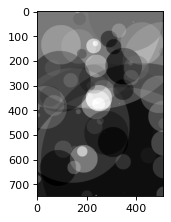

 71%|███████████████████████▌         | 21400/30000 [9:01:37<5:13:44,  2.19s/it]

Iteration 21400 : best score = 1286.33319432, mean score = 1286.63329135.


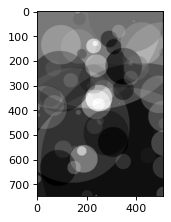

 72%|███████████████████████▋         | 21500/30000 [9:05:16<5:13:29,  2.21s/it]

Iteration 21500 : best score = 1285.75981068, mean score = 1285.99244843.


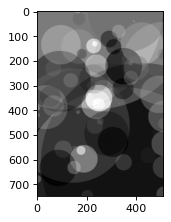

 72%|███████████████████████▊         | 21600/30000 [9:08:55<5:06:41,  2.19s/it]

Iteration 21600 : best score = 1284.57922449, mean score = 1284.75874590.


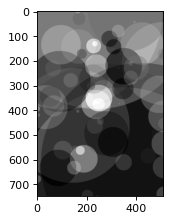

 72%|███████████████████████▊         | 21700/30000 [9:12:35<5:02:54,  2.19s/it]

Iteration 21700 : best score = 1283.81807687, mean score = 1284.03824128.


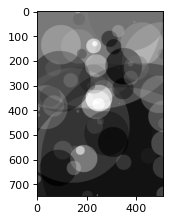

 73%|███████████████████████▉         | 21800/30000 [9:16:14<5:00:22,  2.20s/it]

Iteration 21800 : best score = 1283.07097995, mean score = 1283.28162979.


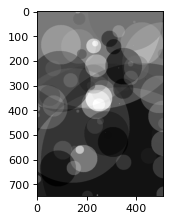

 73%|████████████████████████         | 21900/30000 [9:19:54<4:55:19,  2.19s/it]

Iteration 21900 : best score = 1280.71734039, mean score = 1281.72196642.


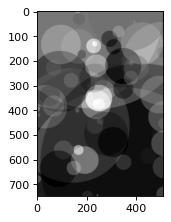

 73%|████████████████████████▏        | 22000/30000 [9:23:33<4:51:49,  2.19s/it]

Iteration 22000 : best score = 1279.55228526, mean score = 1280.27991734.


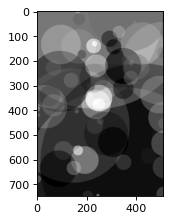

 74%|████████████████████████▎        | 22100/30000 [9:27:12<4:48:23,  2.19s/it]

Iteration 22100 : best score = 1277.31536696, mean score = 1277.86967879.


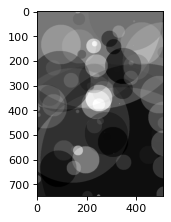

 74%|████████████████████████▍        | 22200/30000 [9:30:52<4:45:02,  2.19s/it]

Iteration 22200 : best score = 1275.61262244, mean score = 1275.84706723.


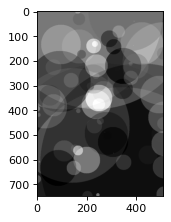

 74%|████████████████████████▌        | 22300/30000 [9:34:31<4:41:41,  2.20s/it]

Iteration 22300 : best score = 1274.14028962, mean score = 1274.54055353.


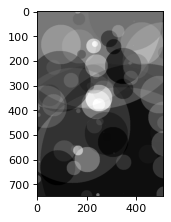

Added more circles of radius_scale=0.0625, mutation scale=0.009090909090909092.
 New population shape: (32, 88, 5)


 75%|████████████████████████▋        | 22400/30000 [9:38:34<5:04:26,  2.40s/it]

Iteration 22400 : best score = 1280.88923465, mean score = 1281.37230866.


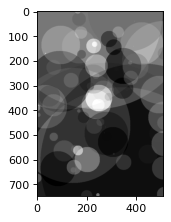

 75%|████████████████████████▊        | 22500/30000 [9:42:34<5:00:50,  2.41s/it]

Iteration 22500 : best score = 1277.12293783, mean score = 1277.48525017.


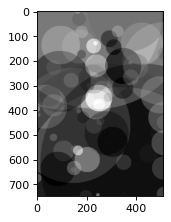

 75%|████████████████████████▊        | 22600/30000 [9:46:35<4:56:44,  2.41s/it]

Iteration 22600 : best score = 1274.87348980, mean score = 1275.02457456.


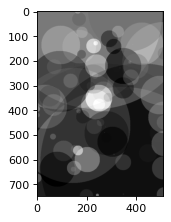

 76%|████████████████████████▉        | 22700/30000 [9:50:36<4:52:53,  2.41s/it]

Iteration 22700 : best score = 1272.41175759, mean score = 1273.00713273.


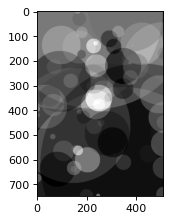

 76%|█████████████████████████        | 22800/30000 [9:54:37<4:48:45,  2.41s/it]

Iteration 22800 : best score = 1271.14948940, mean score = 1271.66648264.


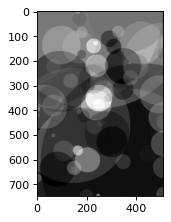

 76%|█████████████████████████▏       | 22900/30000 [9:58:37<4:44:41,  2.41s/it]

Iteration 22900 : best score = 1269.42140194, mean score = 1269.73302227.


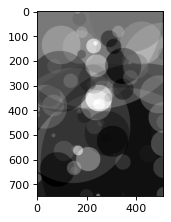

 77%|████████████████████████▌       | 23000/30000 [10:02:38<4:40:42,  2.41s/it]

Iteration 23000 : best score = 1267.68959909, mean score = 1268.02215654.


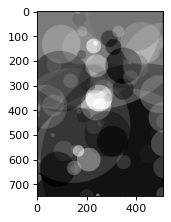

 77%|████████████████████████▋       | 23100/30000 [10:06:39<4:36:30,  2.40s/it]

Iteration 23100 : best score = 1266.56003303, mean score = 1266.81321175.


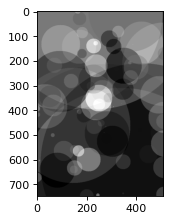

 77%|████████████████████████▋       | 23200/30000 [10:10:40<4:32:21,  2.40s/it]

Iteration 23200 : best score = 1265.53024541, mean score = 1265.74542802.


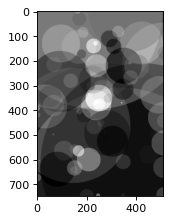

 78%|████████████████████████▊       | 23300/30000 [10:14:41<4:28:59,  2.41s/it]

Iteration 23300 : best score = 1264.10321295, mean score = 1264.48843329.


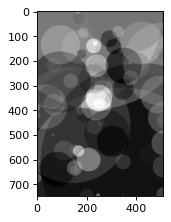

 78%|████████████████████████▉       | 23400/30000 [10:18:42<4:24:30,  2.40s/it]

Iteration 23400 : best score = 1263.50597382, mean score = 1263.76702652.


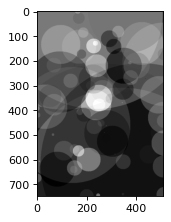

 78%|█████████████████████████       | 23500/30000 [10:22:42<4:20:21,  2.40s/it]

Iteration 23500 : best score = 1262.30859061, mean score = 1262.80982740.


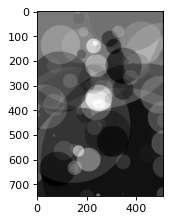

 79%|█████████████████████████▏      | 23600/30000 [10:26:43<4:17:20,  2.41s/it]

Iteration 23600 : best score = 1262.04860008, mean score = 1262.21013644.


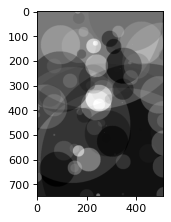

 79%|█████████████████████████▎      | 23700/30000 [10:30:44<4:12:30,  2.40s/it]

Iteration 23700 : best score = 1261.32628757, mean score = 1261.45402903.


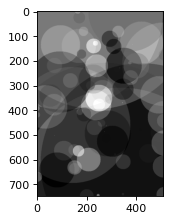

 79%|█████████████████████████▍      | 23800/30000 [10:34:45<4:08:45,  2.41s/it]

Iteration 23800 : best score = 1260.69351067, mean score = 1260.88493471.


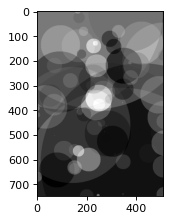

 80%|█████████████████████████▍      | 23900/30000 [10:38:46<4:04:51,  2.41s/it]

Iteration 23900 : best score = 1259.81450680, mean score = 1260.27400857.


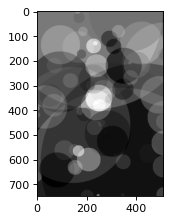

 80%|█████████████████████████▌      | 24000/30000 [10:42:47<4:00:38,  2.41s/it]

Iteration 24000 : best score = 1258.63540249, mean score = 1258.93541914.


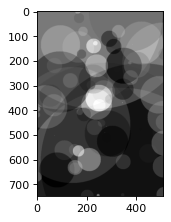

 80%|█████████████████████████▋      | 24100/30000 [10:46:48<3:56:41,  2.41s/it]

Iteration 24100 : best score = 1257.28331801, mean score = 1257.58836292.


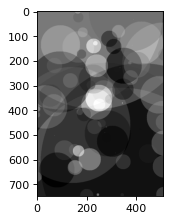

 81%|█████████████████████████▊      | 24200/30000 [10:50:49<3:52:40,  2.41s/it]

Iteration 24200 : best score = 1255.63495339, mean score = 1256.34916451.


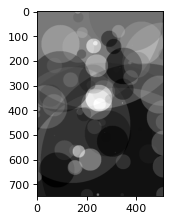

 81%|█████████████████████████▉      | 24300/30000 [10:54:50<3:48:28,  2.41s/it]

Iteration 24300 : best score = 1254.91410029, mean score = 1255.27678152.


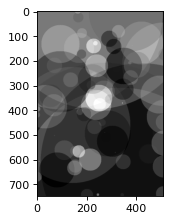

 81%|██████████████████████████      | 24400/30000 [10:58:51<3:44:34,  2.41s/it]

Iteration 24400 : best score = 1254.42979511, mean score = 1254.65992477.


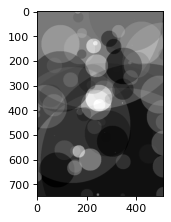

 82%|██████████████████████████▏     | 24500/30000 [11:02:52<3:40:33,  2.41s/it]

Iteration 24500 : best score = 1253.78372646, mean score = 1253.97514191.


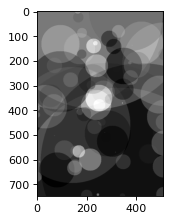

 82%|██████████████████████████▏     | 24600/30000 [11:06:53<3:36:41,  2.41s/it]

Iteration 24600 : best score = 1252.98021442, mean score = 1253.32820434.


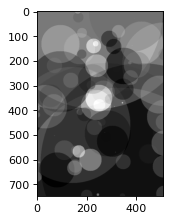

 82%|██████████████████████████▎     | 24700/30000 [11:10:54<3:32:20,  2.40s/it]

Iteration 24700 : best score = 1252.85626682, mean score = 1252.92681701.


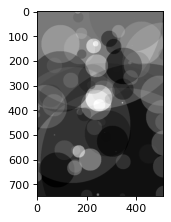

 83%|██████████████████████████▍     | 24800/30000 [11:14:55<3:28:21,  2.40s/it]

Iteration 24800 : best score = 1252.59037243, mean score = 1252.75499856.


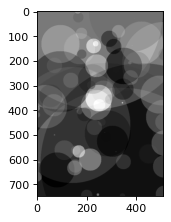

 83%|██████████████████████████▌     | 24900/30000 [11:18:55<3:24:30,  2.41s/it]

Iteration 24900 : best score = 1252.07596508, mean score = 1252.38624729.


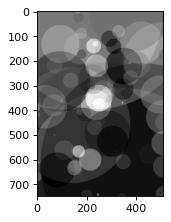

 83%|██████████████████████████▋     | 25000/30000 [11:22:56<3:20:50,  2.41s/it]

Iteration 25000 : best score = 1251.78786890, mean score = 1251.92318939.


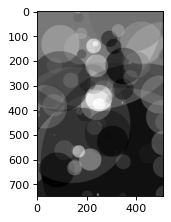

 84%|██████████████████████████▊     | 25100/30000 [11:26:58<3:16:24,  2.40s/it]

Iteration 25100 : best score = 1251.55449133, mean score = 1251.70392806.


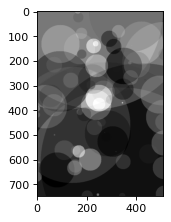

 84%|██████████████████████████▉     | 25200/30000 [11:30:58<3:12:26,  2.41s/it]

Iteration 25200 : best score = 1251.27672495, mean score = 1251.36696803.


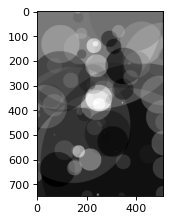

 84%|██████████████████████████▉     | 25300/30000 [11:34:59<3:08:23,  2.41s/it]

Iteration 25300 : best score = 1251.05945678, mean score = 1251.12725656.


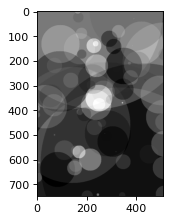

 85%|███████████████████████████     | 25400/30000 [11:39:00<3:05:01,  2.41s/it]

Iteration 25400 : best score = 1250.66963179, mean score = 1250.82041964.


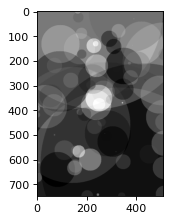

 85%|███████████████████████████▏    | 25500/30000 [11:43:01<3:00:20,  2.40s/it]

Iteration 25500 : best score = 1250.04617946, mean score = 1250.28404150.


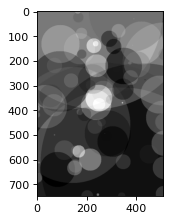

 85%|███████████████████████████▎    | 25600/30000 [11:47:02<2:57:00,  2.41s/it]

Iteration 25600 : best score = 1249.97779907, mean score = 1250.02755151.


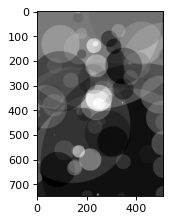

 86%|███████████████████████████▍    | 25700/30000 [11:51:03<2:52:42,  2.41s/it]

Iteration 25700 : best score = 1249.82379133, mean score = 1249.94244528.


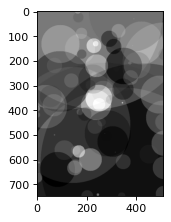

 86%|███████████████████████████▌    | 25800/30000 [11:55:04<2:49:37,  2.42s/it]

Iteration 25800 : best score = 1249.67400306, mean score = 1249.79488059.


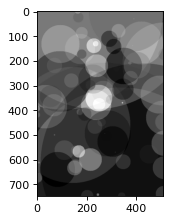

 86%|███████████████████████████▋    | 25900/30000 [11:59:05<2:44:30,  2.41s/it]

Iteration 25900 : best score = 1249.42906768, mean score = 1249.53631540.


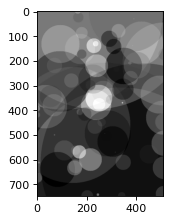

 87%|███████████████████████████▋    | 26000/30000 [12:03:06<2:40:27,  2.41s/it]

Iteration 26000 : best score = 1248.93045460, mean score = 1249.04952516.


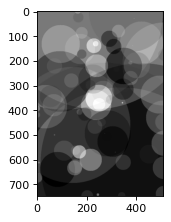

 87%|███████████████████████████▊    | 26100/30000 [12:07:07<2:36:41,  2.41s/it]

Iteration 26100 : best score = 1248.77871970, mean score = 1248.88677601.


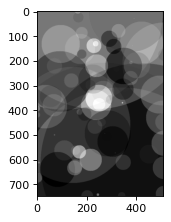

 87%|███████████████████████████▉    | 26200/30000 [12:11:08<2:32:38,  2.41s/it]

Iteration 26200 : best score = 1248.37206165, mean score = 1248.64143306.


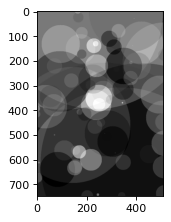

 88%|████████████████████████████    | 26300/30000 [12:15:10<2:28:30,  2.41s/it]

Iteration 26300 : best score = 1247.98284519, mean score = 1248.12872659.


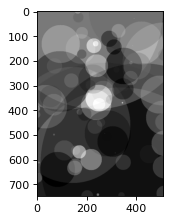

 88%|████████████████████████████▏   | 26400/30000 [12:19:11<2:24:21,  2.41s/it]

Iteration 26400 : best score = 1247.63699363, mean score = 1247.77439224.


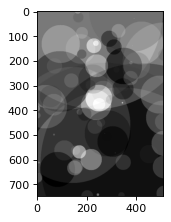

 88%|████████████████████████████▎   | 26500/30000 [12:23:12<2:20:27,  2.41s/it]

Iteration 26500 : best score = 1247.35080470, mean score = 1247.47418549.


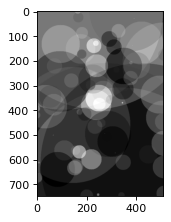

 89%|████████████████████████████▎   | 26600/30000 [12:27:13<2:16:41,  2.41s/it]

Iteration 26600 : best score = 1247.07060539, mean score = 1247.22174455.


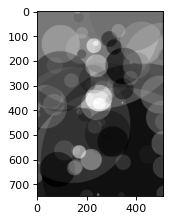

 89%|████████████████████████████▍   | 26700/30000 [12:31:14<2:12:37,  2.41s/it]

Iteration 26700 : best score = 1246.83020981, mean score = 1246.95394772.


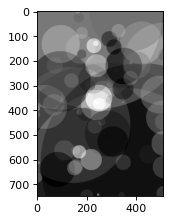

Added more circles of radius_scale=0.0625, mutation scale=0.008333333333333333.
 New population shape: (32, 96, 5)


 89%|████████████████████████████▌   | 26800/30000 [12:35:38<2:19:44,  2.62s/it]

Iteration 26800 : best score = 1260.55663418, mean score = 1261.38143743.


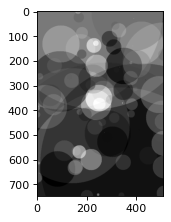

 90%|████████████████████████████▋   | 26900/30000 [12:40:01<2:15:17,  2.62s/it]

Iteration 26900 : best score = 1257.10097558, mean score = 1257.62333994.


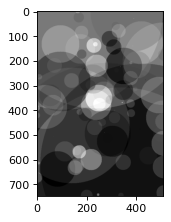

 90%|████████████████████████████▊   | 27000/30000 [12:44:23<2:10:56,  2.62s/it]

Iteration 27000 : best score = 1255.41710202, mean score = 1256.13465521.


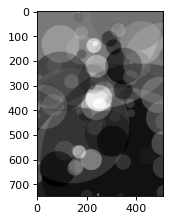

 90%|████████████████████████████▉   | 27100/30000 [12:48:45<2:06:44,  2.62s/it]

Iteration 27100 : best score = 1254.01065060, mean score = 1254.55004051.


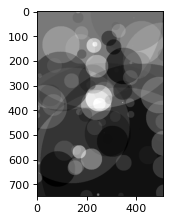

 91%|█████████████████████████████   | 27200/30000 [12:53:08<2:02:07,  2.62s/it]

Iteration 27200 : best score = 1253.58622429, mean score = 1253.64857914.


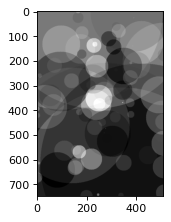

 91%|█████████████████████████████   | 27300/30000 [12:57:30<1:57:58,  2.62s/it]

Iteration 27300 : best score = 1252.14458073, mean score = 1252.40730522.


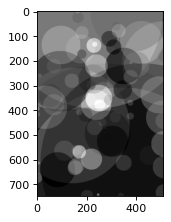

 91%|█████████████████████████████▏  | 27400/30000 [13:01:52<1:53:33,  2.62s/it]

Iteration 27400 : best score = 1250.48600569, mean score = 1250.79631717.


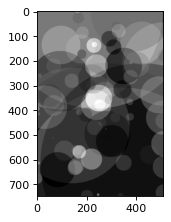

 92%|█████████████████████████████▎  | 27500/30000 [13:06:15<1:49:12,  2.62s/it]

Iteration 27500 : best score = 1248.88093761, mean score = 1249.29306796.


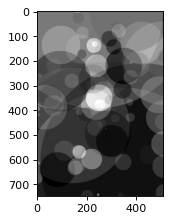

 92%|█████████████████████████████▍  | 27600/30000 [13:10:37<1:44:45,  2.62s/it]

Iteration 27600 : best score = 1248.08187884, mean score = 1248.24007296.


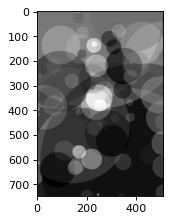

 92%|█████████████████████████████▌  | 27700/30000 [13:14:59<1:40:27,  2.62s/it]

Iteration 27700 : best score = 1247.47027870, mean score = 1247.70401036.


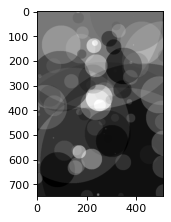

 93%|█████████████████████████████▋  | 27800/30000 [13:19:22<1:35:54,  2.62s/it]

Iteration 27800 : best score = 1246.62357362, mean score = 1246.98140955.


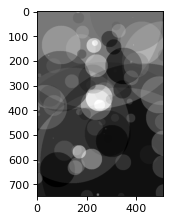

 93%|█████████████████████████████▊  | 27900/30000 [13:23:44<1:31:41,  2.62s/it]

Iteration 27900 : best score = 1245.52263483, mean score = 1246.07006564.


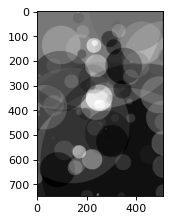

 93%|█████████████████████████████▊  | 28000/30000 [13:28:06<1:27:37,  2.63s/it]

Iteration 28000 : best score = 1245.05292763, mean score = 1245.22969467.


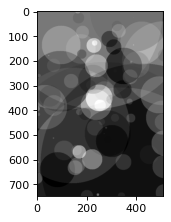

 94%|█████████████████████████████▉  | 28100/30000 [13:32:29<1:22:59,  2.62s/it]

Iteration 28100 : best score = 1244.47455702, mean score = 1244.82915540.


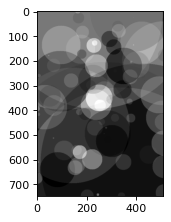

 94%|██████████████████████████████  | 28200/30000 [13:36:51<1:18:32,  2.62s/it]

Iteration 28200 : best score = 1244.15455894, mean score = 1244.25923454.


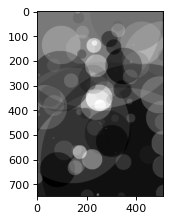

 94%|██████████████████████████████▏ | 28300/30000 [13:41:13<1:14:20,  2.62s/it]

Iteration 28300 : best score = 1243.78347297, mean score = 1243.94161791.


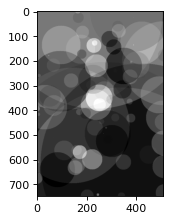

 95%|██████████████████████████████▎ | 28400/30000 [13:45:35<1:09:45,  2.62s/it]

Iteration 28400 : best score = 1243.45679896, mean score = 1243.61968976.


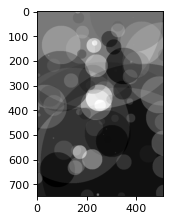

 95%|██████████████████████████████▍ | 28500/30000 [13:49:57<1:05:25,  2.62s/it]

Iteration 28500 : best score = 1243.13352708, mean score = 1243.27576678.


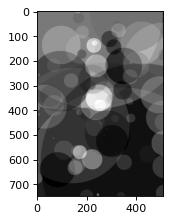

 95%|██████████████████████████████▌ | 28600/30000 [13:54:20<1:01:13,  2.62s/it]

Iteration 28600 : best score = 1242.72868013, mean score = 1242.92093081.


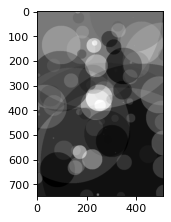

 96%|████████████████████████████████▌ | 28700/30000 [13:58:42<56:43,  2.62s/it]

Iteration 28700 : best score = 1242.20784330, mean score = 1242.44324875.


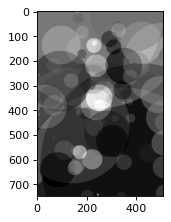

 96%|████████████████████████████████▋ | 28800/30000 [14:03:04<52:27,  2.62s/it]

Iteration 28800 : best score = 1241.89159798, mean score = 1241.99635726.


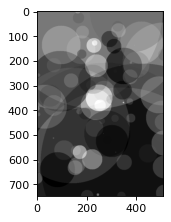

 96%|████████████████████████████████▊ | 28900/30000 [14:07:27<48:00,  2.62s/it]

Iteration 28900 : best score = 1241.37404551, mean score = 1241.52890283.


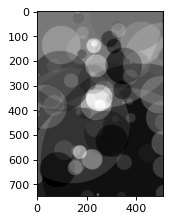

 97%|████████████████████████████████▊ | 29000/30000 [14:11:49<43:40,  2.62s/it]

Iteration 29000 : best score = 1240.91998362, mean score = 1241.03702779.


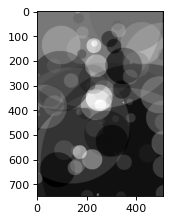

 97%|████████████████████████████████▉ | 29100/30000 [14:16:11<39:22,  2.63s/it]

Iteration 29100 : best score = 1240.75387658, mean score = 1240.81089142.


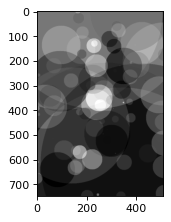

 97%|█████████████████████████████████ | 29200/30000 [14:20:34<34:57,  2.62s/it]

Iteration 29200 : best score = 1240.31306440, mean score = 1240.54098180.


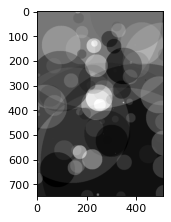

 98%|█████████████████████████████████▏| 29300/30000 [14:24:56<30:33,  2.62s/it]

Iteration 29300 : best score = 1240.11252427, mean score = 1240.20058782.


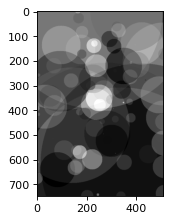

 98%|█████████████████████████████████▎| 29400/30000 [14:29:18<26:12,  2.62s/it]

Iteration 29400 : best score = 1239.72116552, mean score = 1239.84010181.


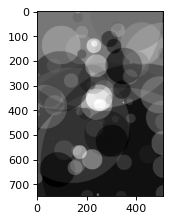

 98%|█████████████████████████████████▍| 29500/30000 [14:33:41<21:49,  2.62s/it]

Iteration 29500 : best score = 1239.55725282, mean score = 1239.65207031.


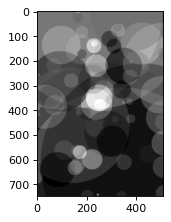

 99%|█████████████████████████████████▌| 29600/30000 [14:38:03<17:27,  2.62s/it]

Iteration 29600 : best score = 1239.00423759, mean score = 1239.29967270.


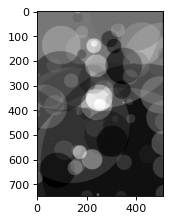

 99%|█████████████████████████████████▋| 29700/30000 [14:42:25<13:06,  2.62s/it]

Iteration 29700 : best score = 1238.81917894, mean score = 1238.92281475.


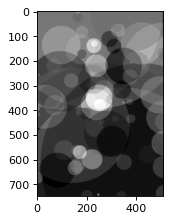

 99%|█████████████████████████████████▊| 29800/30000 [14:46:47<08:43,  2.62s/it]

Iteration 29800 : best score = 1238.76699265, mean score = 1238.81730258.


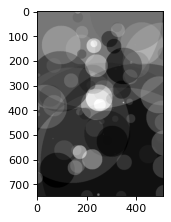

100%|█████████████████████████████████▉| 29900/30000 [14:51:10<04:21,  2.62s/it]

Iteration 29900 : best score = 1238.65535894, mean score = 1238.72304354.


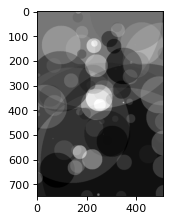

100%|█████████████████████████████████▉| 29999/30000 [14:55:29<00:02,  2.63s/it]

Iteration 29999 : best score = 1238.42136967, mean score = 1238.52572380.


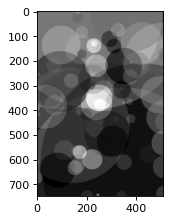

100%|██████████████████████████████████| 30000/30000 [14:55:32<00:00,  1.79s/it]


In [399]:
'''def es(
    objective_function, 
    individual_size,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
number_of_offspring_per_parent  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1
):'''
no_iters=30000


best_solution_objective_value, best_solution, \
log_objective_values, log_best_solutions, population=es(MSE_objective_f, 
                                             chromosome_length=8,
                                             population_size=32,
                                            number_of_iterations=no_iters,
                                            number_of_parents=6,
                                            number_of_offspring_per_parent=6,

                                            genotype_length=5, gray=True,

                                            pararell=True, log_frequency=100)
np.save('./last_population', population)

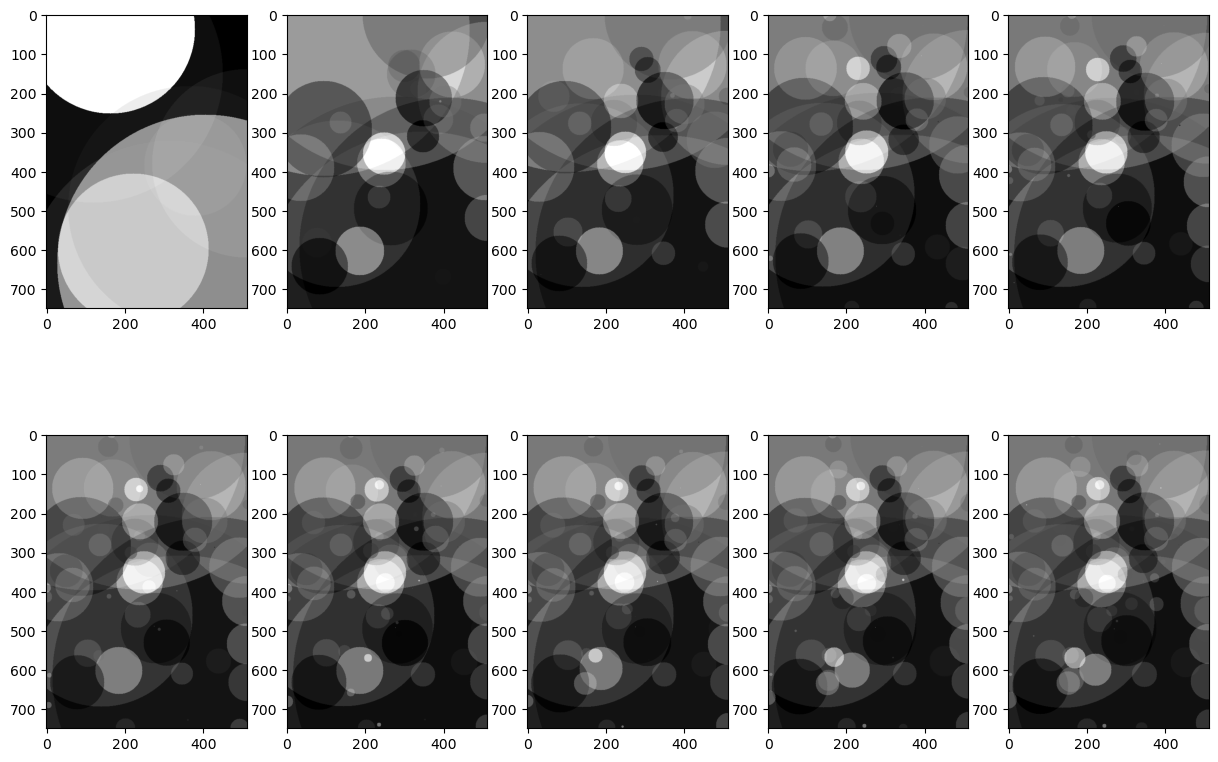

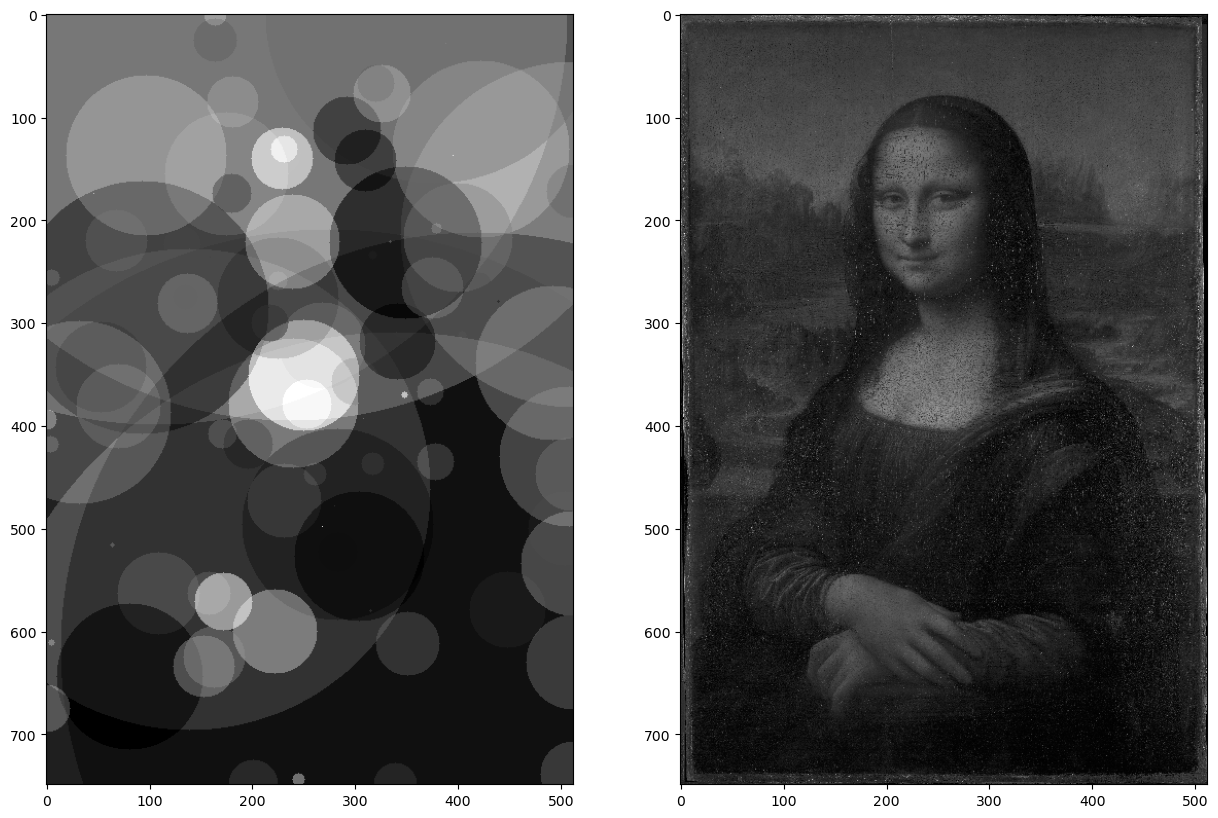

In [400]:
mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions[:-1]):
    if i%mod_val==0:
        axs[row_counter, col_counter].imshow(represent_individual(X), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(represent_individual(best_solution), cmap='gray')
axs[1].imshow(target_img, cmap='gray')
plt.show()

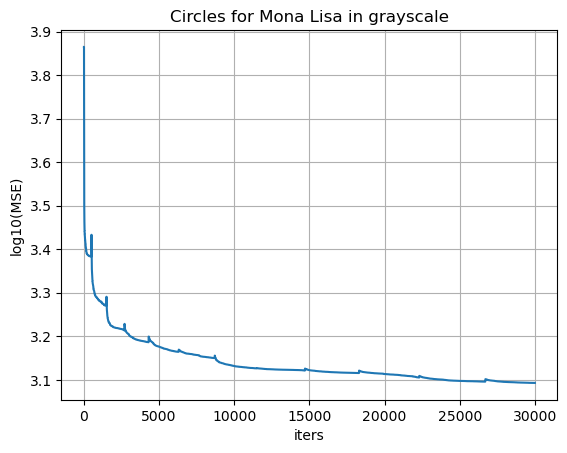

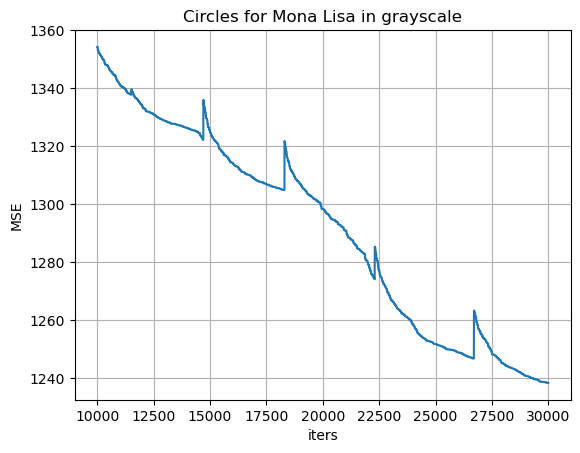

In [412]:
plt.plot(np.log10(log_objective_values[:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('log10(MSE)')
plt.xlabel('iters')

plt.show()

plt.plot(np.arange(10000, 30000), (log_objective_values[10000:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('MSE')
plt.xlabel('iters')

plt.show()

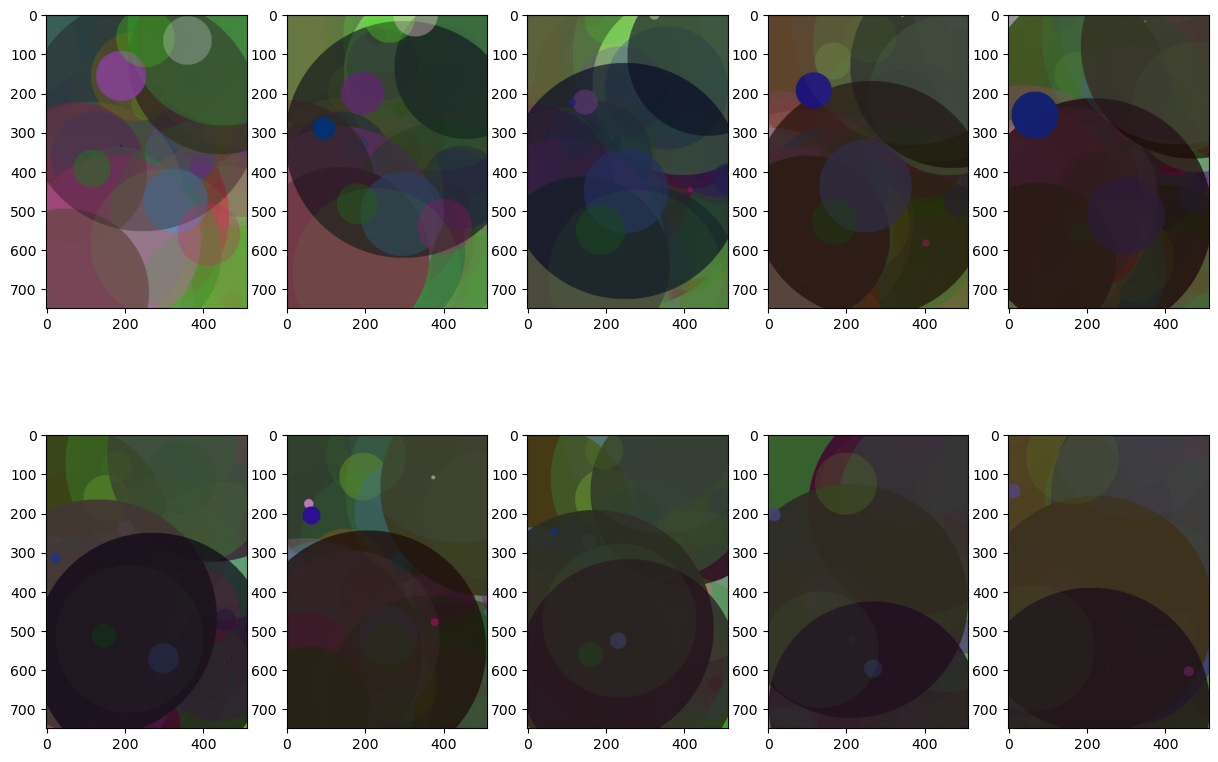

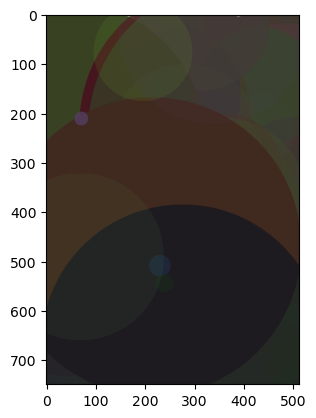

In [49]:

fig, axs = plt.subplots(log_best_solutions.shape[0]//50, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
    if i%10==0:
        axs[row_counter, col_counter].imshow(represent_individual(X))
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()
draw_individual(represent_individual(best_solution))